# Read AIS, North & South Cable Data

Here we take in the AIS data to be able to plot the paths that the vessels have taken to see if the go near the cables.
We then take this data to directly compare them and track which vessels have passed over the cables and exactly when that occured.


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates
from datetime import datetime
from pyproj import Proj

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def CalculateGreatCircleDistanceUsingHaversine(lon1, lat1, lon2, lat2):
    
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    
    dlat = lat2 - lat1

    a    =  math.sin(0.5*dlat) ** 2 \
          + math.cos(    lat1)      \
          * math.cos(    lat2)      \
          * math.sin(0.5*dlon) ** 2
    
    return 2 * 6371 * math.asin( math.sqrt( a ) )

In this section we take the AIS data from the csv files as well as the layout and locations of the cables. 

In [2]:
myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

df_AisTypes = pd.read_csv(r'../../Documentation/AisData/AisVesselTypes.csv')

AisFilename = r'../../Documentation/AisData/AIS_167528271268456143_461-1675282713663.csv'
df_Ais = pd.read_csv(AisFilename) 
df_Ais['DateTimeUTC'] = pd.to_datetime(df_Ais['BaseDateTime'])

x,y = myProj(df_Ais['LON'].values, df_Ais['LAT'].values)
df_Ais['Easting' ] = x
df_Ais['Northing'] = y

df_Ais['Type'] = [df_AisTypes[str(t)].values[0] for t in df_Ais['VesselType'].values]

df_Ais.to_csv(AisFilename)

df_SouthCable= pd.read_csv(r'../../Documentation/CableGeometries/SouthCable_Geometry.csv')
df_SouthCable.describe()

df_NorthCable= pd.read_csv(r'../../Documentation/CableGeometries/NorthCable_Geometry.csv')
df_NorthCable.describe()


Unnamed: 0       Station        Length        Easting      Northing  \
count  31518.000000  31518.000000  31518.000000   31518.000000  3.151800e+04   
mean   15758.500000  16700.500000      2.044761  392732.227387  5.009304e+06   
std     9098.607229   9098.607229      0.365958   17886.641355  3.672371e+03   
min        0.000000    942.000000      0.000000  362576.157100  5.004869e+06   
25%     7879.250000   8821.250000      1.665085  377188.082150  5.005389e+06   
50%    15758.500000  16700.500000      2.059680  392591.716050  5.008829e+06   
75%    23637.750000  24579.750000      2.397917  408111.701775  5.012759e+06   
max    31517.000000  32459.000000      2.706210  424042.519200  5.015447e+06   

                LON           LAT         Depth  
count  31518.000000  31518.000000  31518.000000  
mean    -124.366567     45.228820   -293.253889  
std        0.228542      0.030474    175.626116  
min     -124.751020     45.192674   -589.135670  
25%     -124.565425     45.196727   -457.766588  
50%     -124.368145     45.224756   -363.825470  
75%     -124.169817     45.257109   -126.949517  
max     -123.967150     45.280533     11.090885

# Vessels travelling near the cables
Then we begin to extract the details about the journeys of the different vessels over the course of the 5 days so that we can plot that in relation to each other as well as the cables. This allows for a visual to see what vessels travelled near the the location of the cables which we can later use to determine which vessels crossed over the cables.

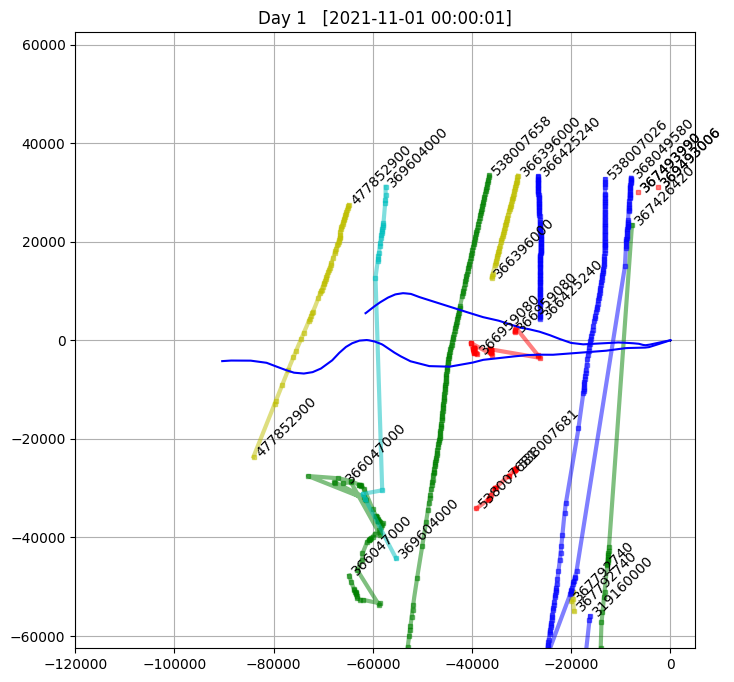

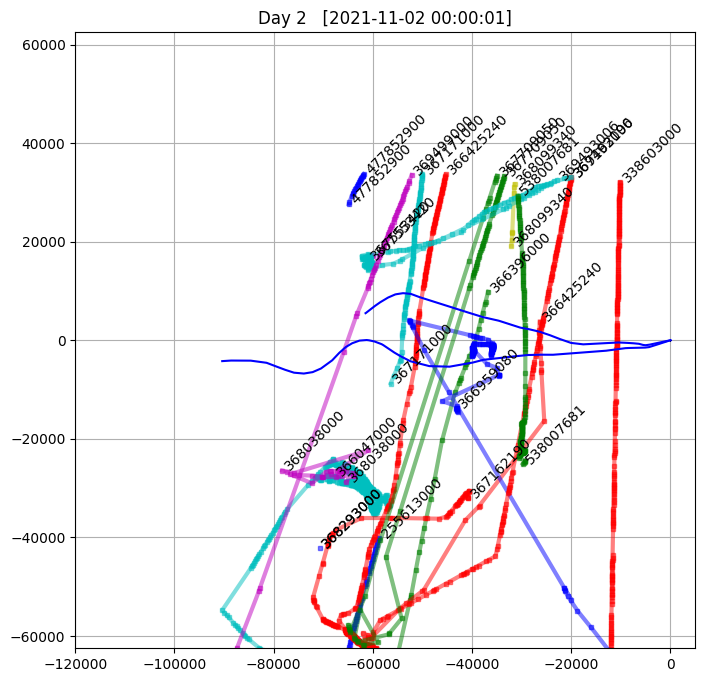

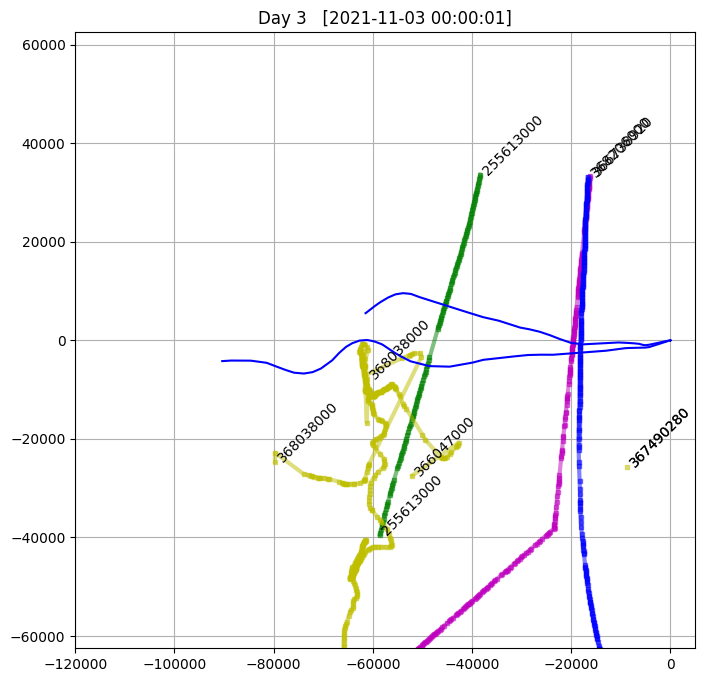

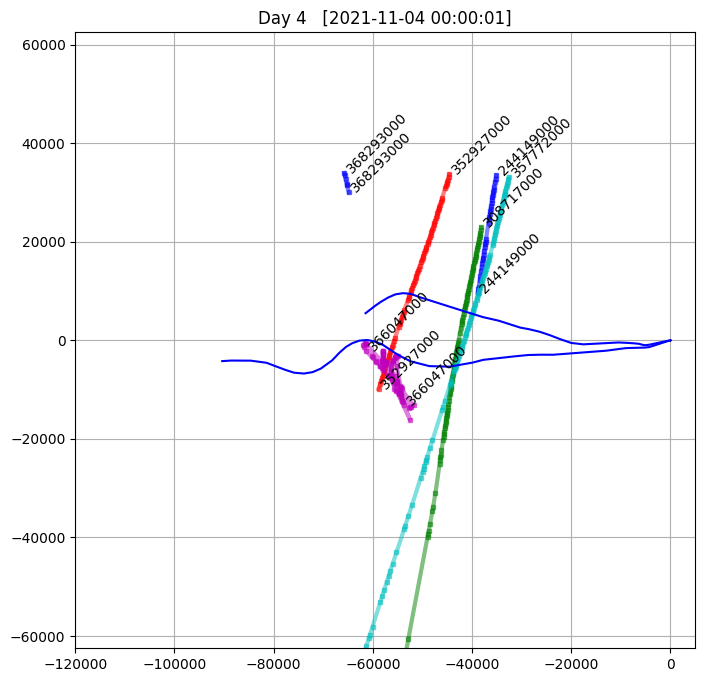

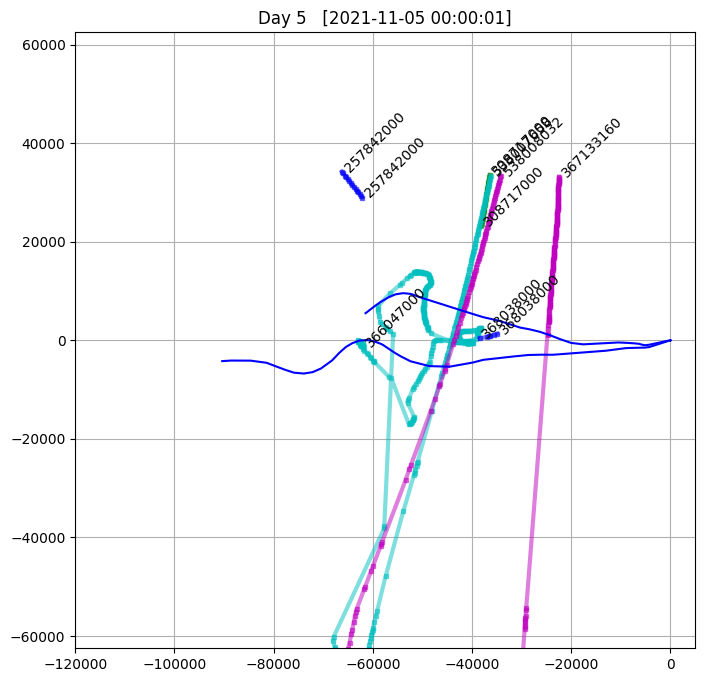

In [3]:
for day in range(1,6):
    
    dd = str(day).zfill(2)
    
    startTime = pd.to_datetime('2021-11-'+dd+'T00:00:01')
    endTime   = pd.to_datetime('2021-11-'+dd+'T23:59:59')

    df_Ais2 = df_Ais[(df_Ais['DateTimeUTC'] > startTime) & (df_Ais['DateTimeUTC'] < endTime)     &\
                     (df_Ais['LON'] > -125.1             ) & (df_Ais['LON'] < -123.5           ) &\
                     (df_Ais['LAT'] > 44.5               ) & (df_Ais['LAT'] < 45.5             ) ]

    
    plt.figure(figsize=(8,8))
    plt.plot(df_Ais2['LON'],df_Ais2['LAT'],'k.',markersize=0.05,alpha=0.1)
    for immsi,mmsi in enumerate(np.unique(df_Ais2['MMSI'].values)):
        colors = ['b','g','r','c','m','y']
    
        c = colors[immsi%len(colors)]
                       
        mask           = df_Ais2 ['MMSI'       ] == mmsi
        vesselEasting  = df_Ais2 ['Easting'    ][mask].values
        vesselNorthing = df_Ais2 ['Northing'   ][mask].values
        vesselTime     = df_Ais2 ['DateTimeUTC'][mask].values
        
        indices        = np.argsort(vesselTime-np.min(vesselTime))
        vesselTime     = vesselTime     [indices]
        vesselEasting  = vesselEasting  [indices]
        vesselNorthing = vesselNorthing [indices]

        time0          = vesselTime[0]

        t = np.array([(t-time0)/ np.timedelta64(1, 's') for t in vesselTime])

        ti = np.arange(t[0],t[-1],15)
        xi = np.interp(ti,t,vesselEasting)
        yi = np.interp(ti,t,vesselNorthing)

        ti = np.array( [(time0+np.timedelta64(tii.astype('int'),'s')) for tii in ti])
        
        plt.plot(xi-df_SouthCable['Easting'][0],
                 yi-df_SouthCable['Northing'][0],'-'+c,alpha=0.5,linewidth=3)
        plt.plot(vesselEasting-df_SouthCable['Easting'][0],
                 vesselNorthing-df_SouthCable['Northing'][0],'s'+c,alpha=0.5,markersize=3)
        
        if vesselNorthing[0]-df_SouthCable['Northing'][0] > -60e3:
            plt.text(vesselEasting [0]-df_SouthCable['Easting' ][0],
                     vesselNorthing[0]-df_SouthCable['Northing'][0],str(mmsi),rotation=45)
        
        if vesselNorthing[-1]-df_SouthCable['Northing'][0] > -60e3:
            plt.text(vesselEasting [-1]-df_SouthCable['Easting' ][0],
                     vesselNorthing[-1]-df_SouthCable['Northing'][0],str(mmsi),rotation=45)
        
    plt.plot(df_SouthCable['Easting']-df_SouthCable['Easting'][0],
             df_SouthCable['Northing']-df_SouthCable['Northing'][0],'b-')
    plt.plot(df_NorthCable['Easting']-df_SouthCable['Easting'][0],
             df_NorthCable['Northing']-df_SouthCable['Northing'][0],'b-')
    plt.title('Day '+str(day)+'   ['+str(startTime)+']')
    plt.grid()
    plt.xlim(-120.e3,5e3)
    plt.ylim(-62.5e3,62.5e3)
    plt.savefig('./Ais_Day'+str(day)+'.png')
    plt.show()

# Find Vessel Crossings

In this section we take the AIS data and compare it directly against the cable location and geometry to find which vessels directly travelled over the cable. This is so those timings could be used so that we know where to look in the cable data as to where events like vessel noise may occur.

244149000 2021-11-03T23:35:18.000000000 382875.9652660602 5001160.531775917
244149000 2021-11-03T23:56:33.000000000 384486.8851028683 5011164.618689025


<Figure size 800x400 with 0 Axes>

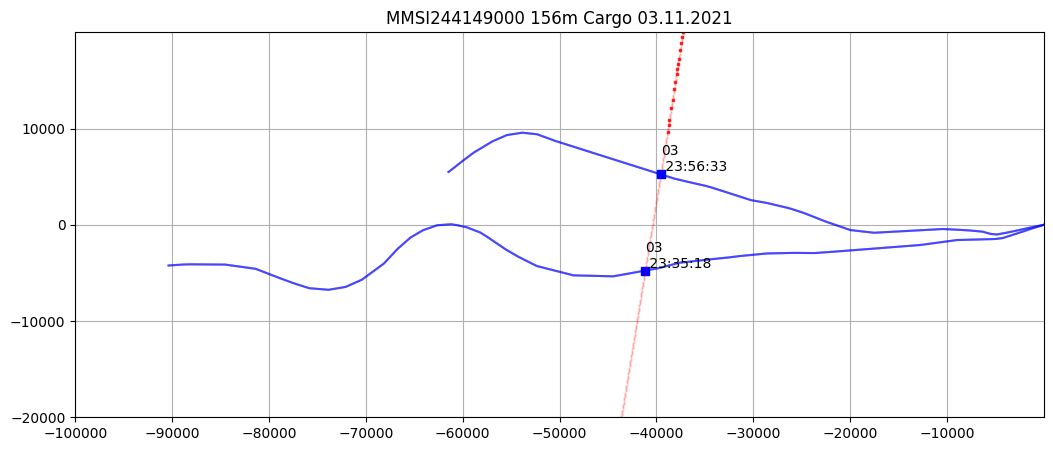

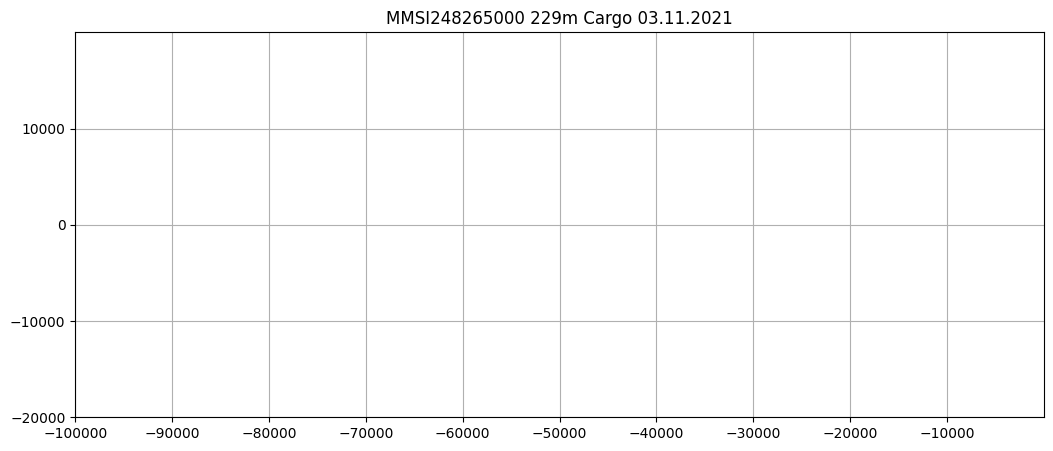

255613000 2021-11-03T01:25:02.000000000 375007.7048782135 5000758.953105453
255613000 2021-11-03T01:57:32.000000000 378565.3060569512 5012996.83920197


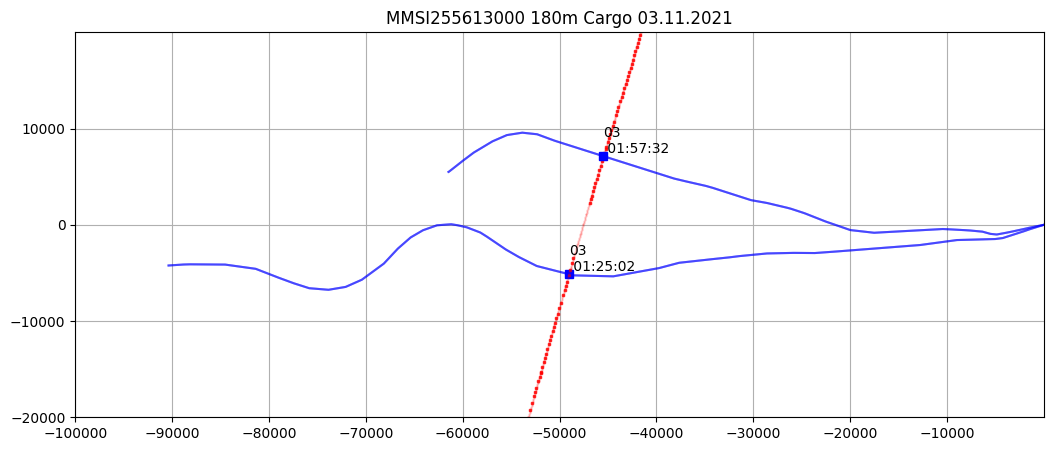

257842000 2021-11-06T01:41:16.000000000 375892.8085760718 5000646.092832581
257842000 2021-11-06T01:04:46.000000000 374859.3059433181 5014217.491203531


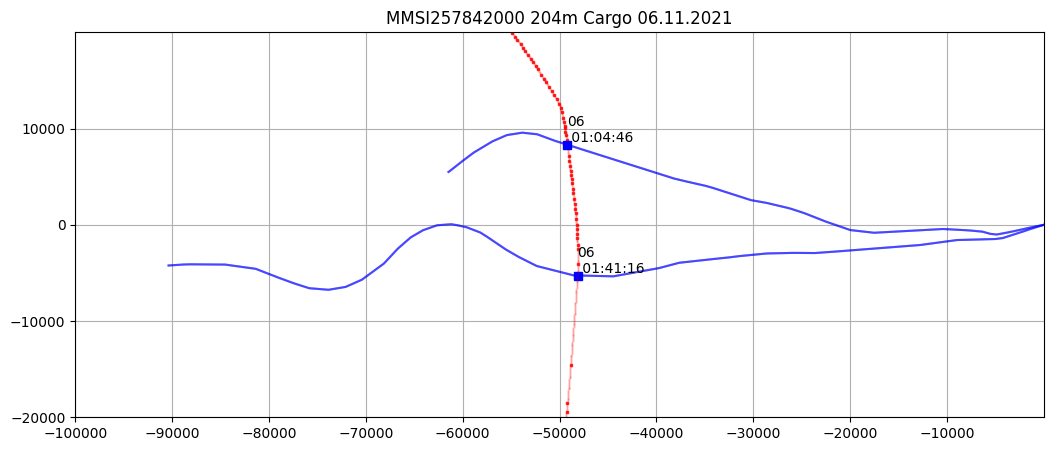

259976000 2021-11-06T09:11:21.000000000 383027.8686246078 5001112.22273219
259976000 2021-11-06T09:31:51.000000000 384637.3303638642 5011117.4474986


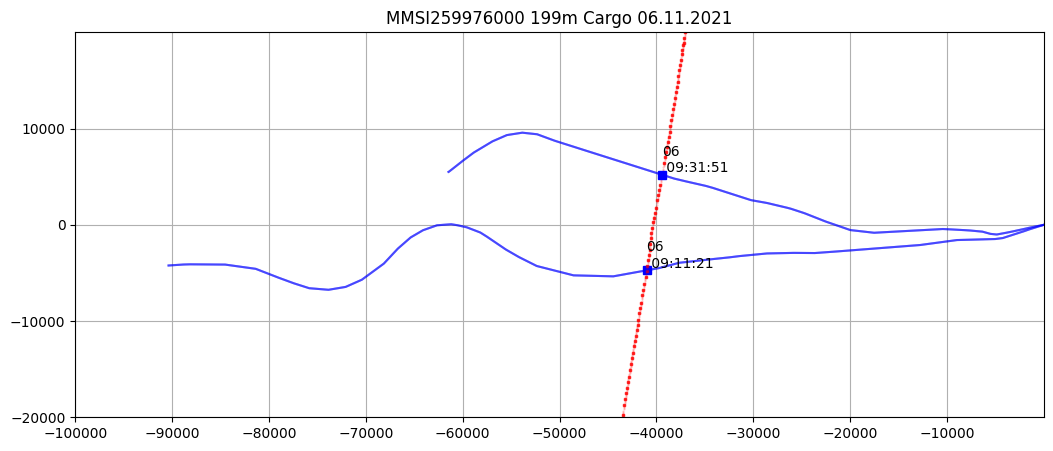

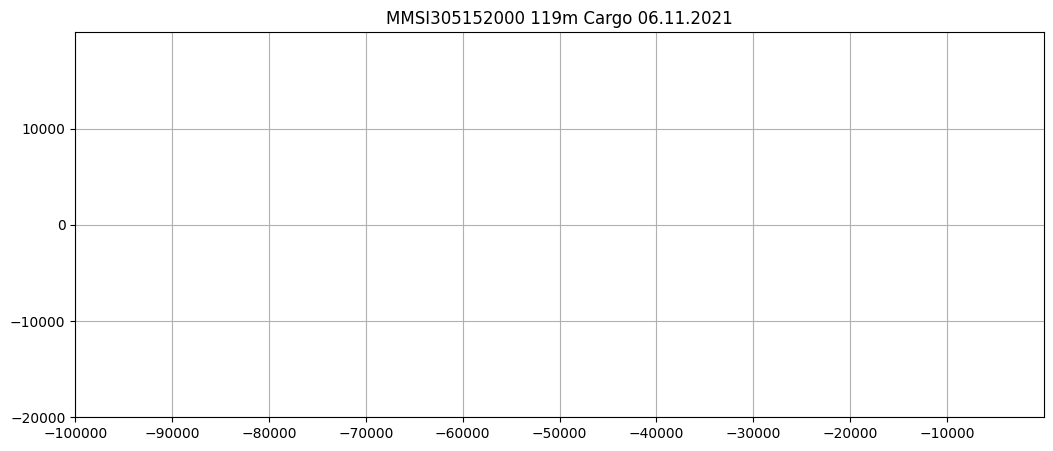

308717000 2021-11-04T22:40:16.000000000 380415.0867439447 5000632.1719388105
308717000 2021-11-04T23:11:46.000000000 382459.9365526042 5011760.625674438


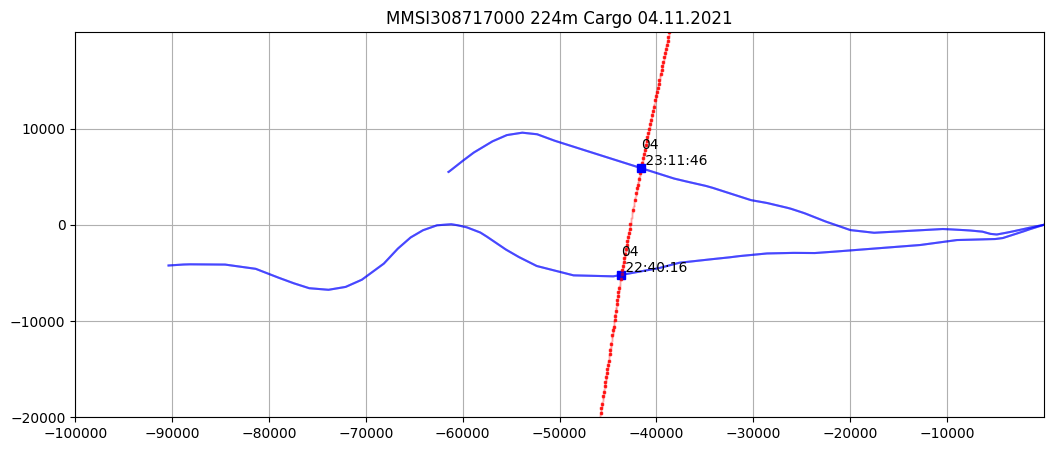

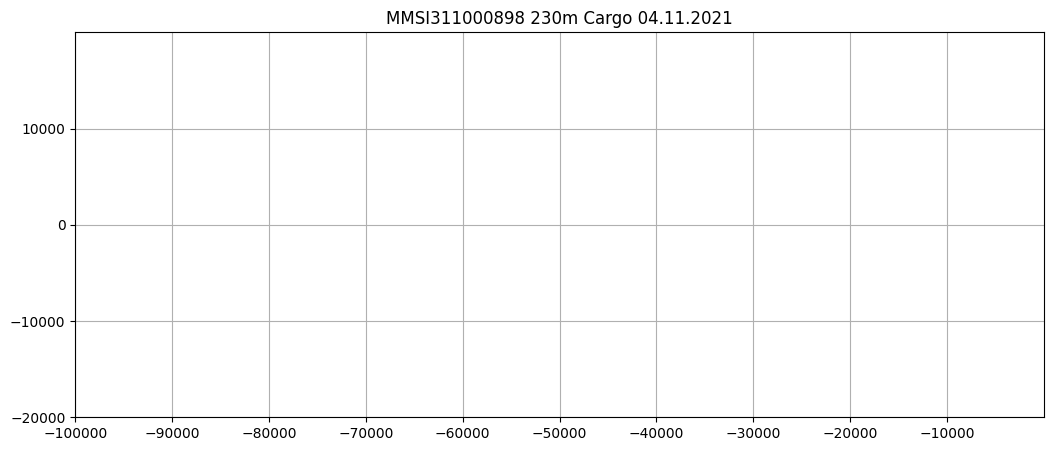

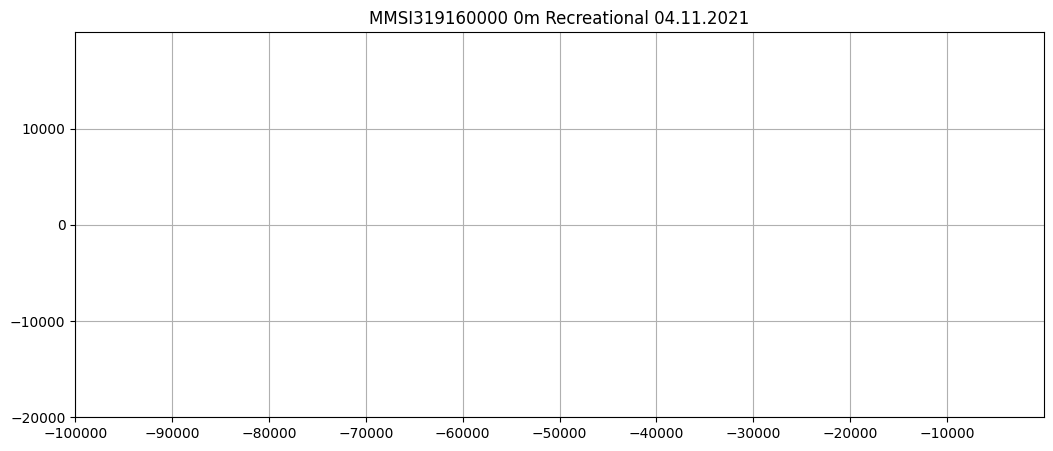

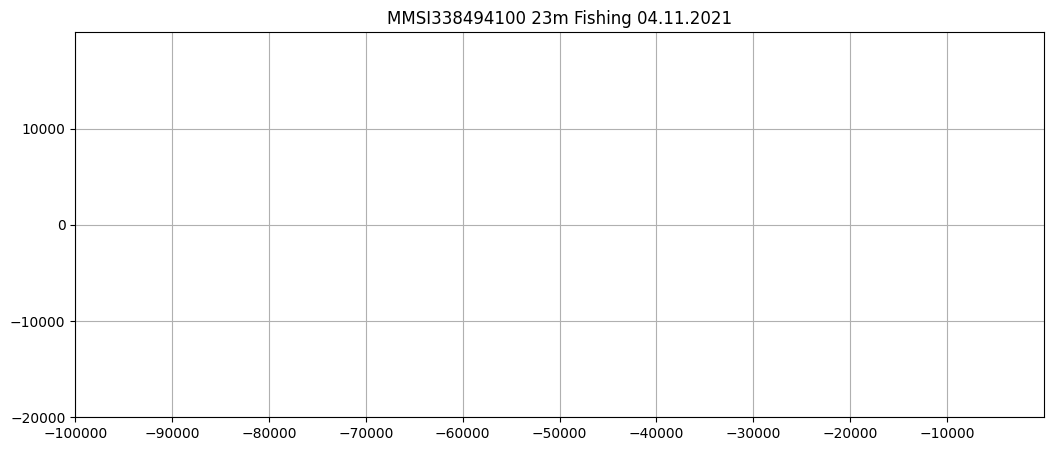

338603000 2021-11-02T11:59:16.000000000 413170.33389841433 5004049.730872777
338603000 2021-11-02T11:53:46.000000000 413198.9436450178 5005400.719968188


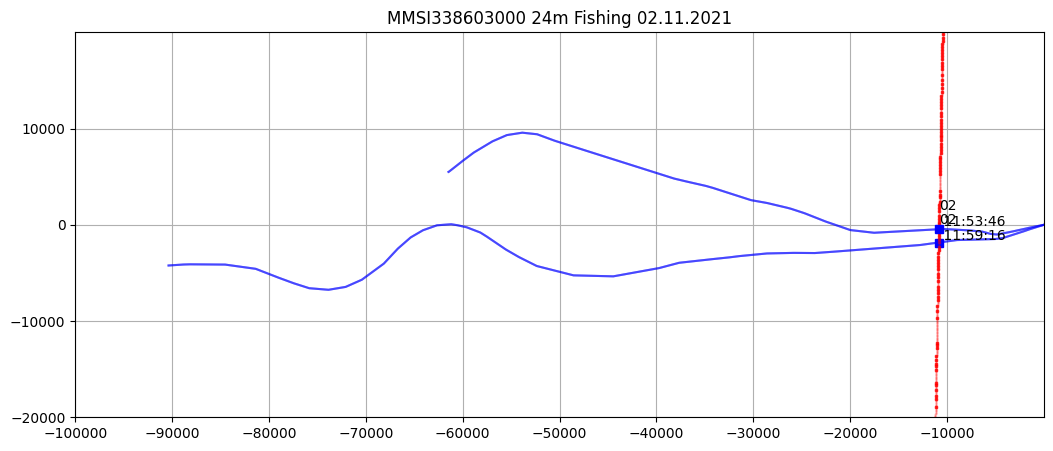

352927000 2021-11-04T02:08:17.000000000 367697.44640680583 5003836.495164539
352927000 2021-11-04T02:38:32.000000000 371555.4072370545 5015278.3402636945


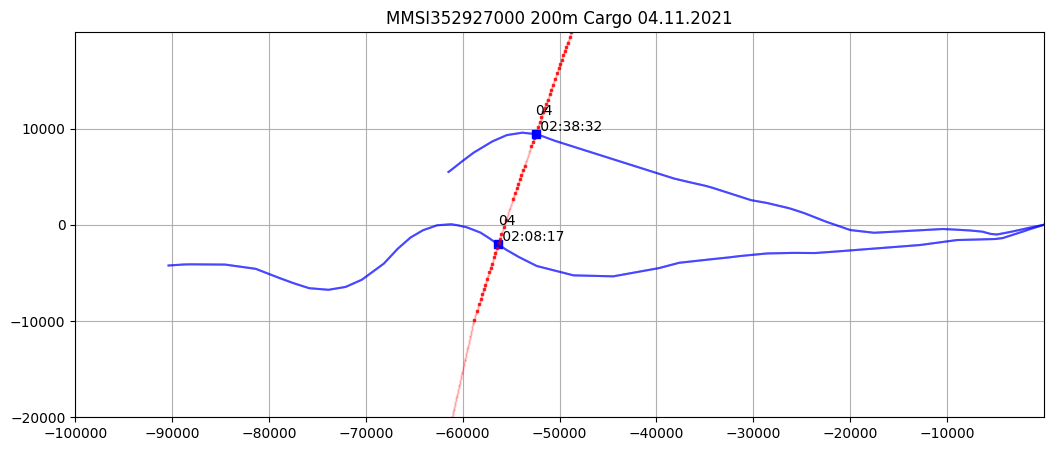

354739000 2021-11-05T14:24:02.000000000 335552.1272449254 5001775.952012005


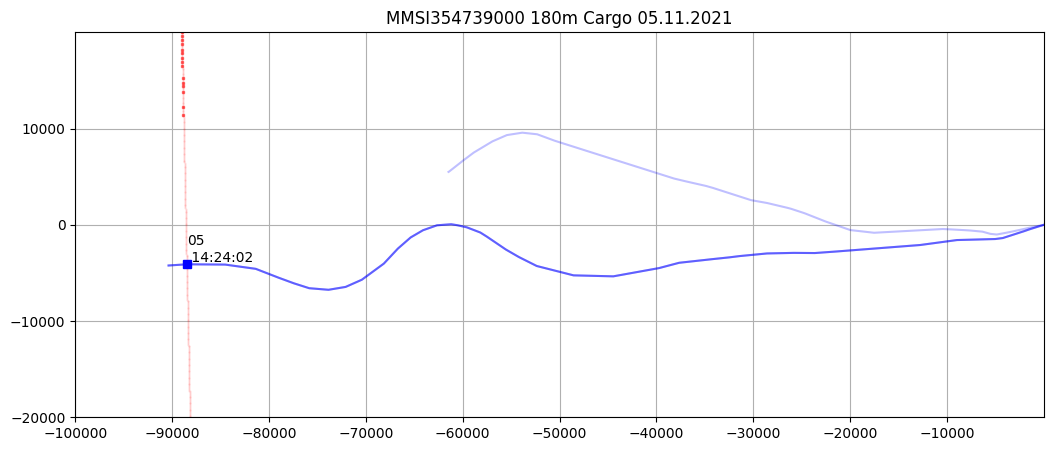

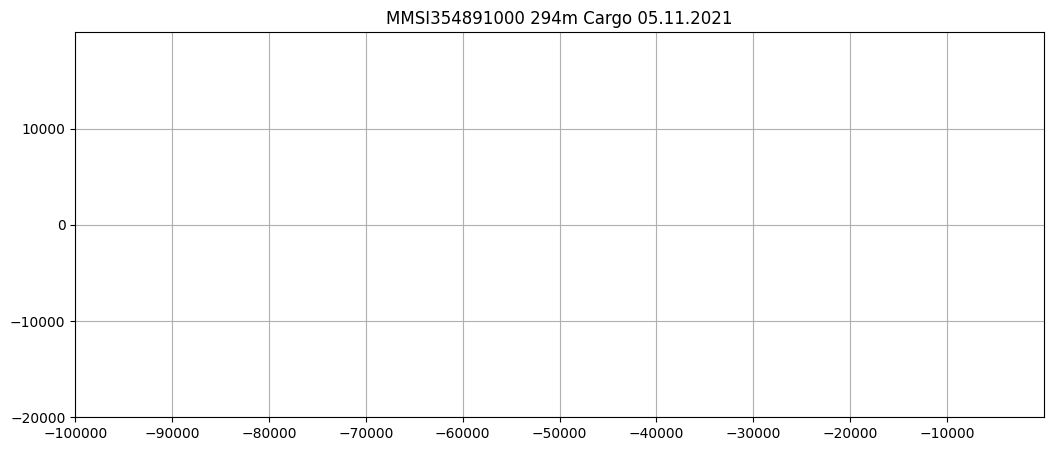

357772000 2021-11-04T10:35:10.000000000 380817.07360080985 5000726.962161868
357772000 2021-11-04T11:00:40.000000000 384078.7747562281 5011250.925290222


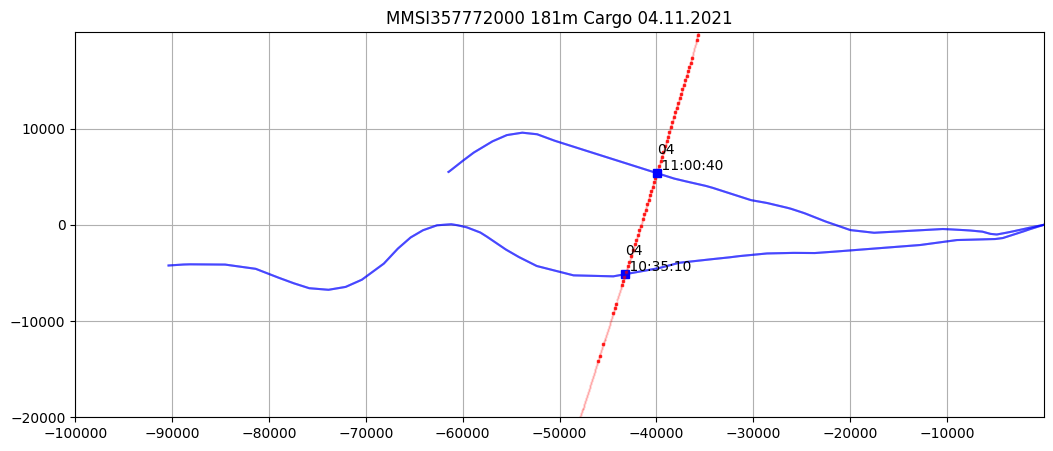

366047000 2021-11-05T00:47:25.000000000 361006.5507395382 5005696.8656123085
366047000 2021-11-05T10:20:40.000000000 374411.7111152804 5014333.193857499


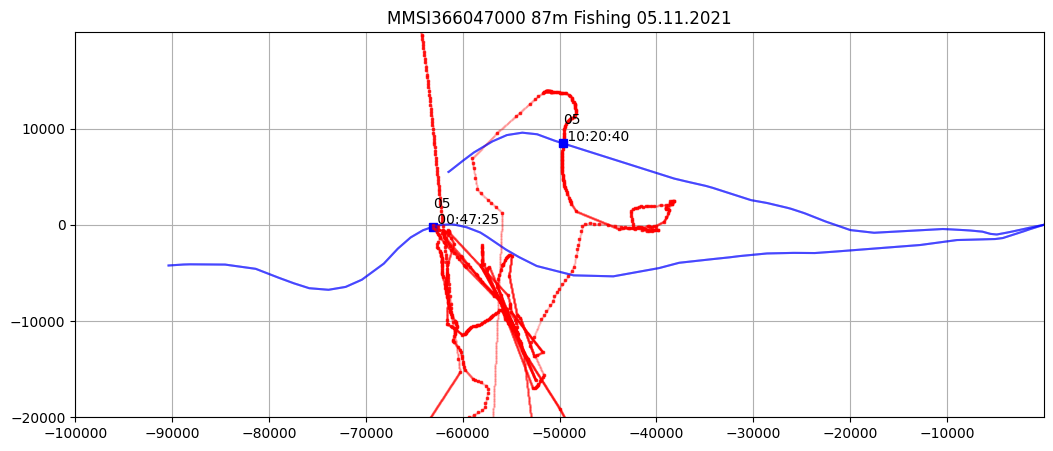

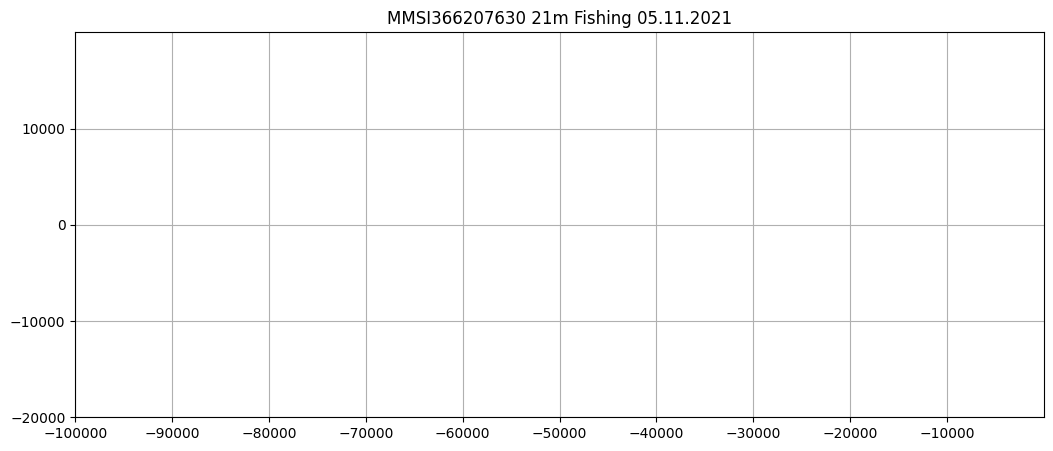

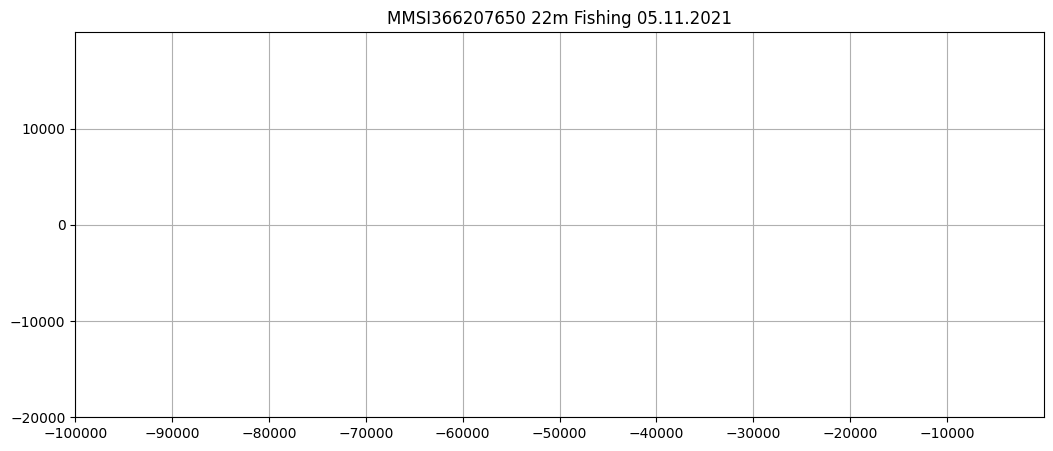

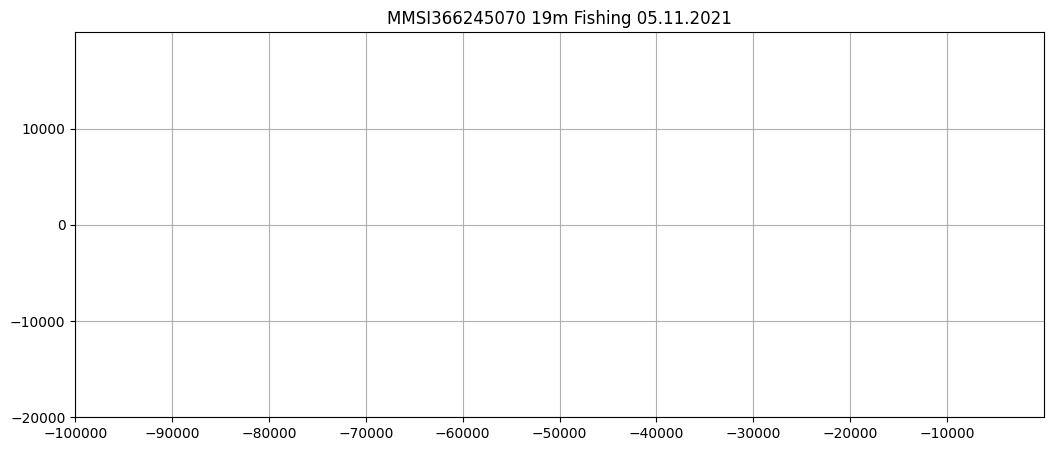

366396000 2021-11-02T00:49:21.000000000 382936.3613129628 5001121.390243538
366396000 2021-11-02T00:17:51.000000000 386004.6648479315 5010623.223334642


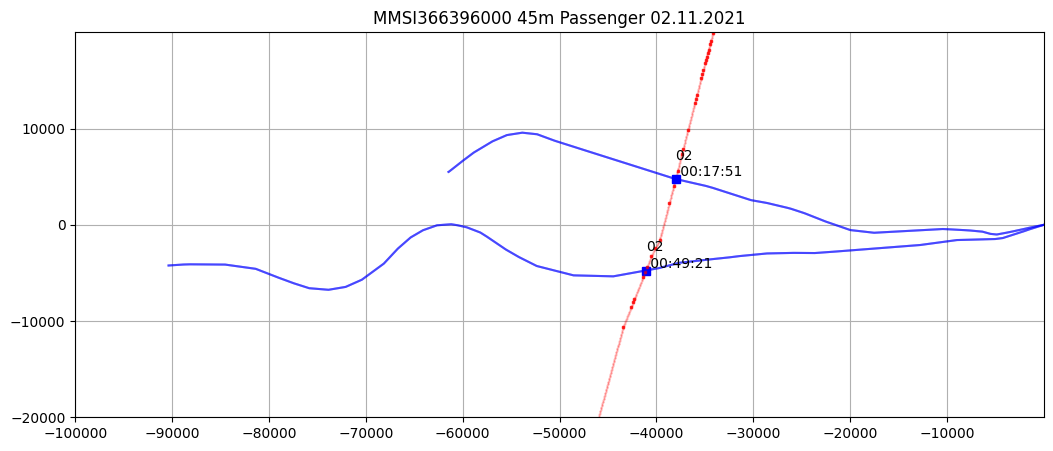

366425240 2021-11-02T13:44:59.000000000 372581.0874095806 5001358.604152233
366425240 2021-11-02T00:09:29.000000000 397581.91506525053 5007637.510664384


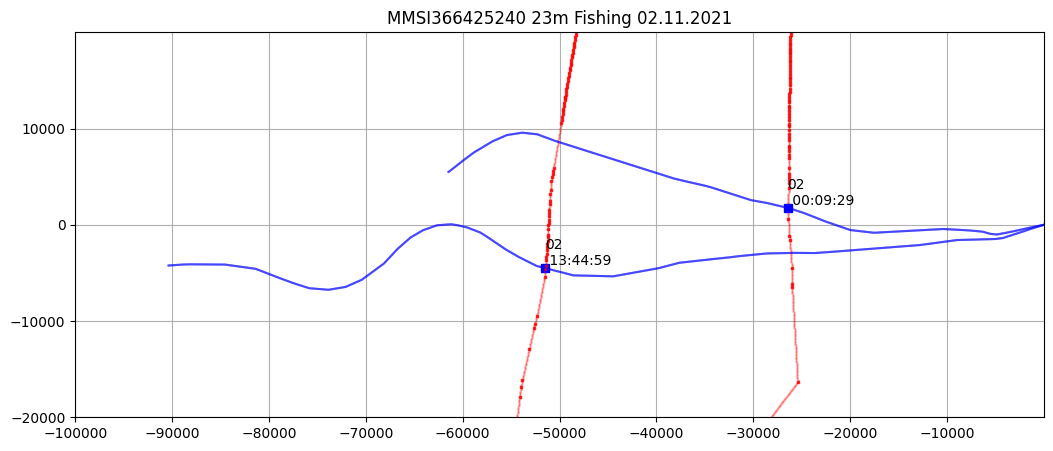

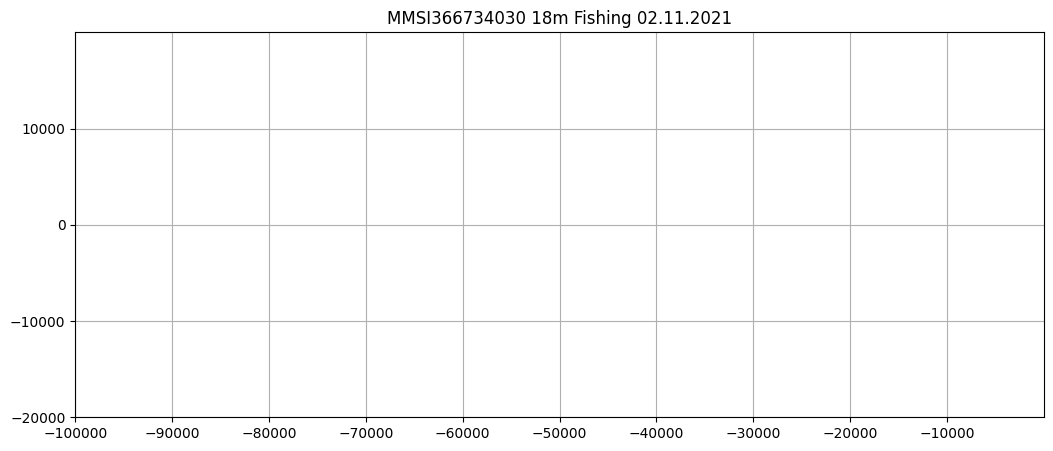

366738920 2021-11-03T13:04:18.000000000 404167.9219411221 5003251.342654536
366738920 2021-11-03T13:12:48.000000000 404371.1339712665 5005282.45647484


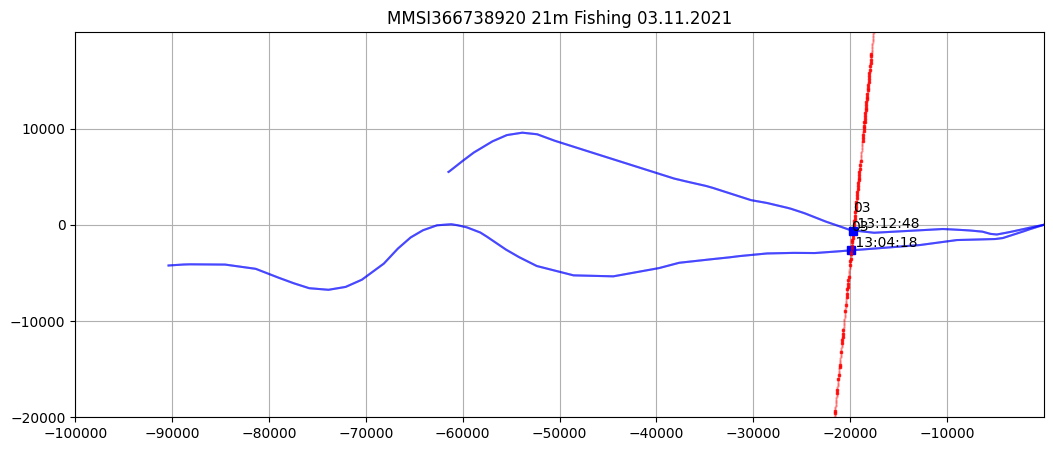

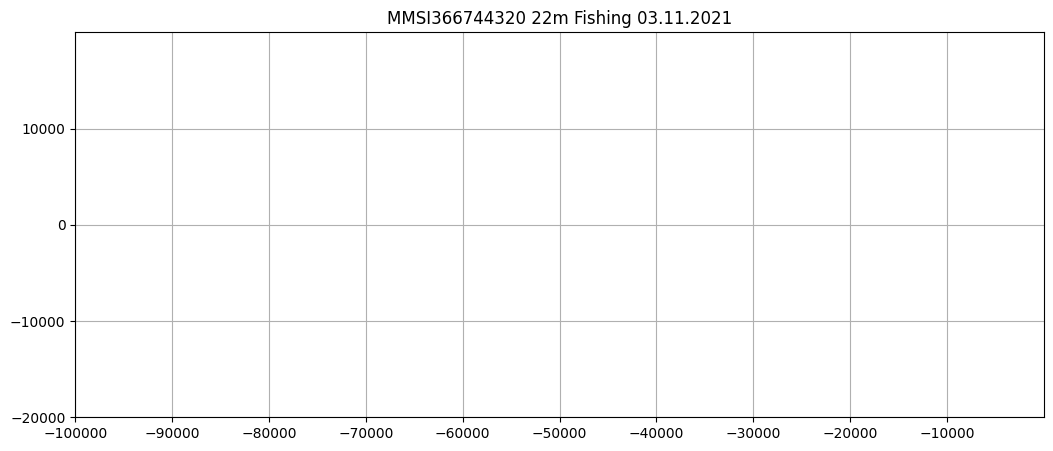

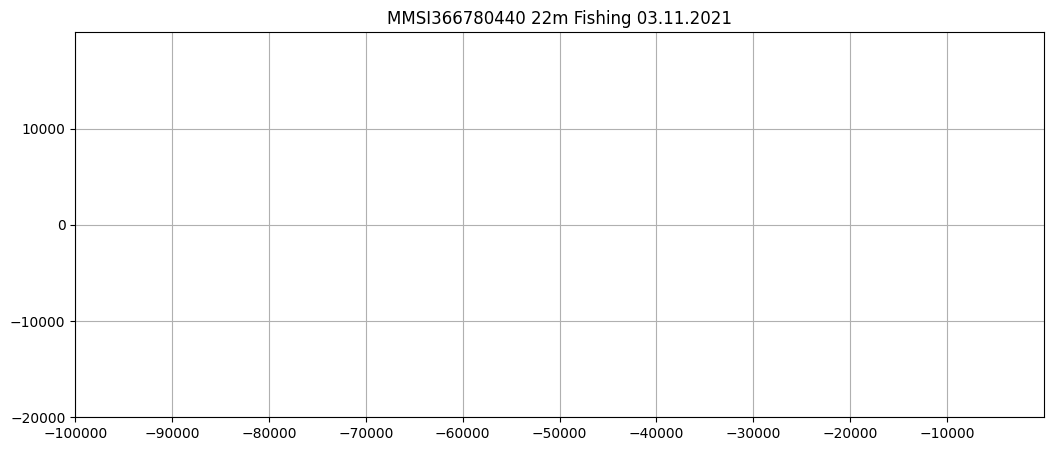

366959080 2021-11-01T15:19:00.000000000 394752.74883797334 5002834.23041767
366959080 2021-11-01T21:40:00.000000000 392840.7307446868 5008495.724515794


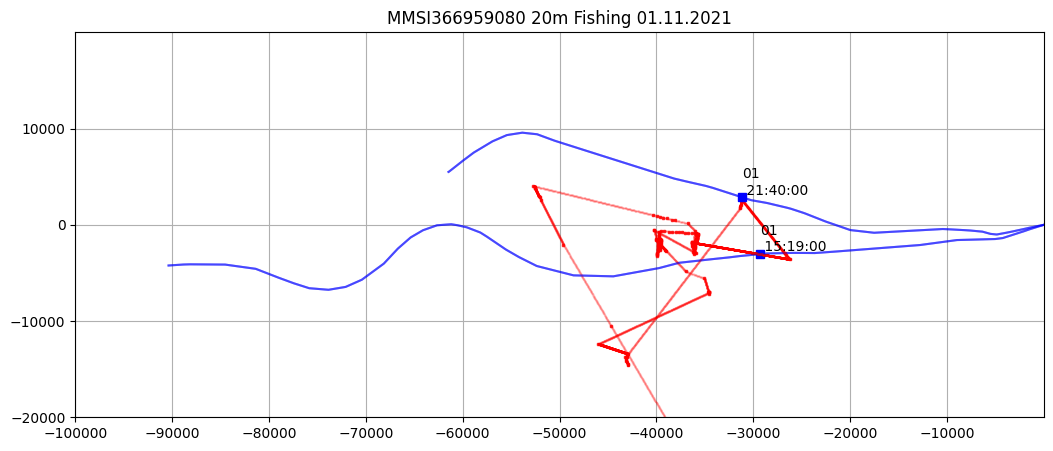

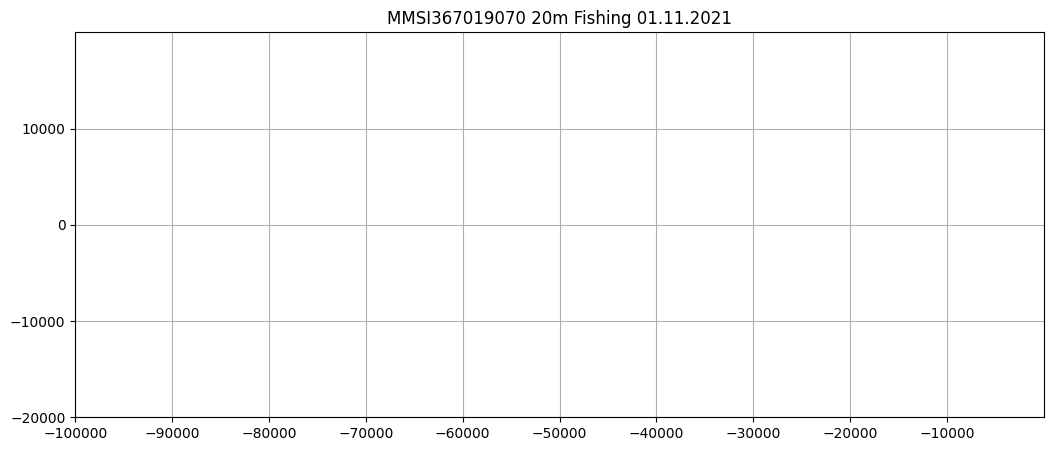

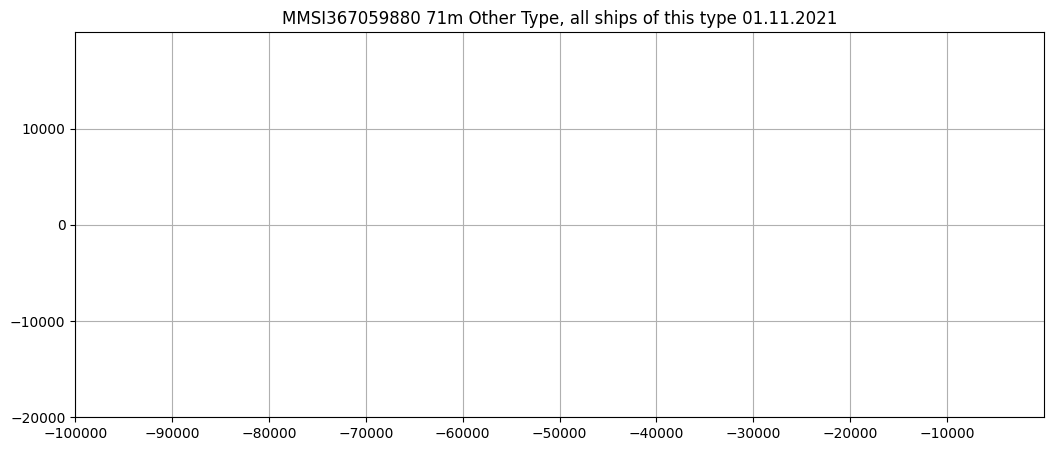

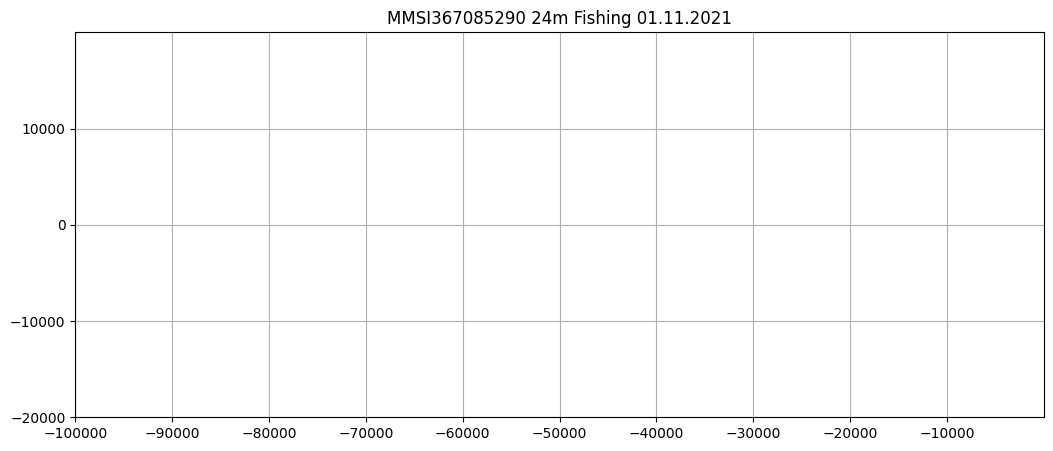

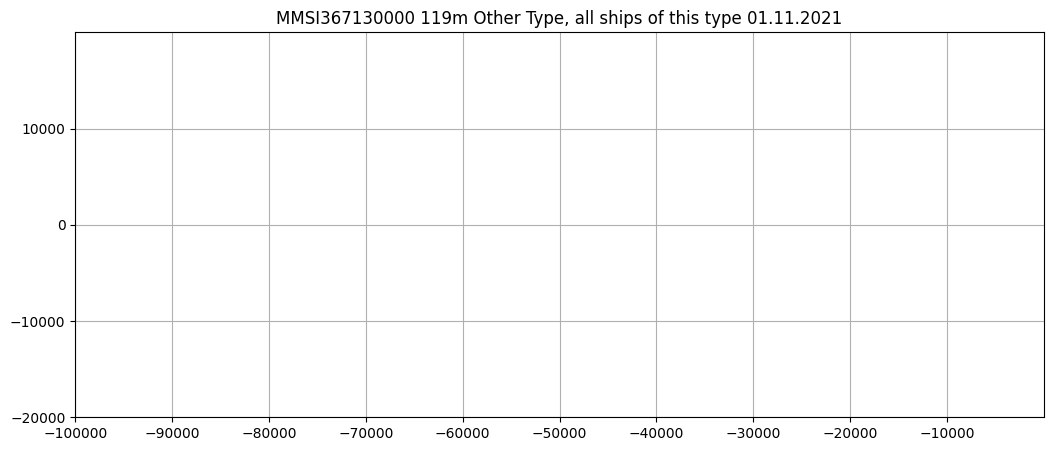

367133160 2021-11-05T07:46:26.000000000 398960.524310759 5002975.572444867
367133160 2021-11-05T08:04:11.000000000 399279.075485719 5007079.291293471


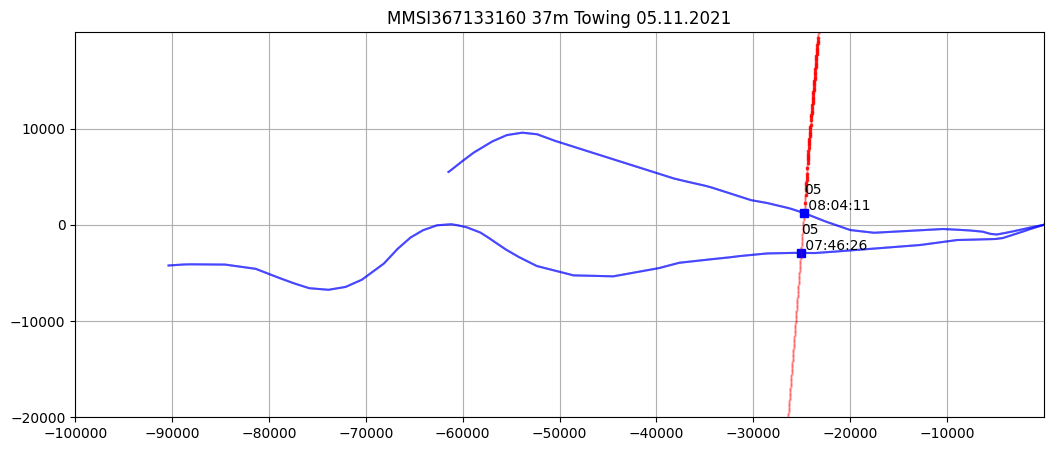

367162190 2021-11-02T08:11:45.000000000 396921.138906381 5002945.047195448
367162190 2021-11-02T07:53:00.000000000 397833.28046924697 5007556.221470218


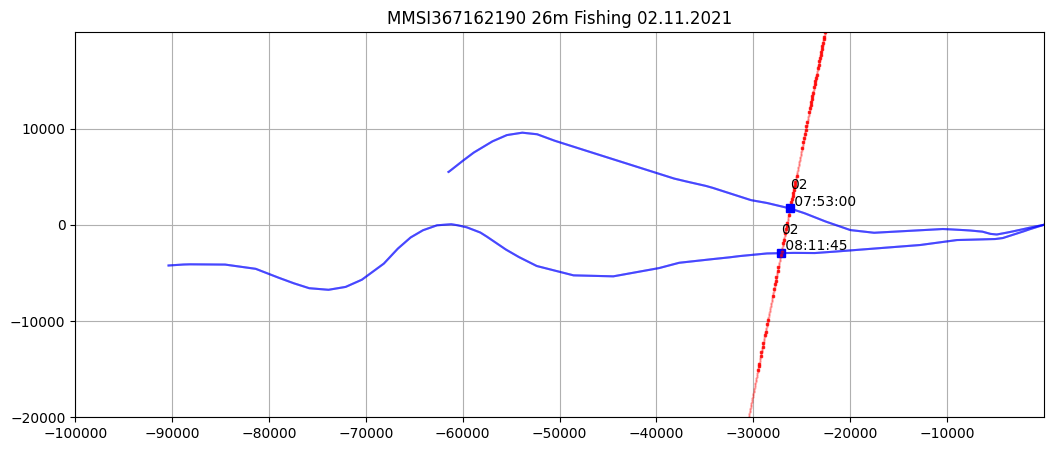

367171000 2021-11-02T12:48:51.000000000 369766.4884853974 5002570.983797714
367171000 2021-11-02T11:48:21.000000000 371056.3510252902 5015370.585410344


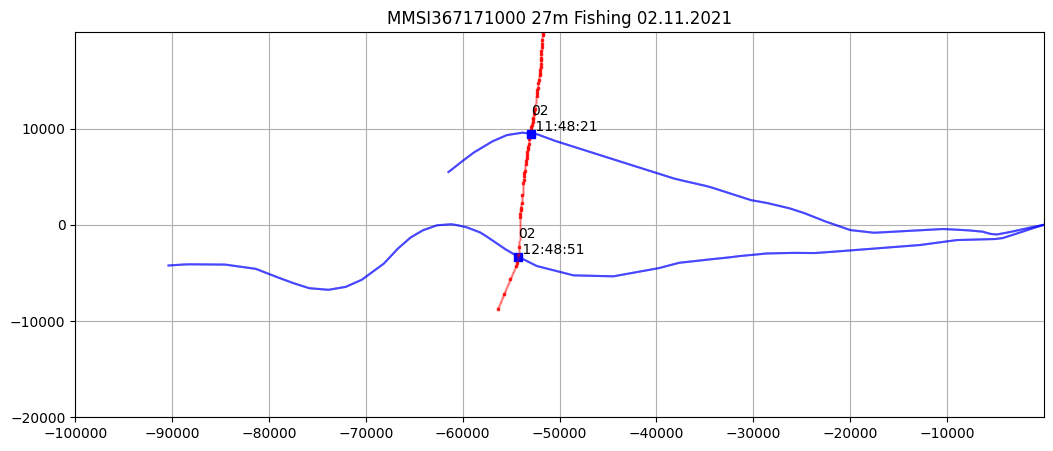

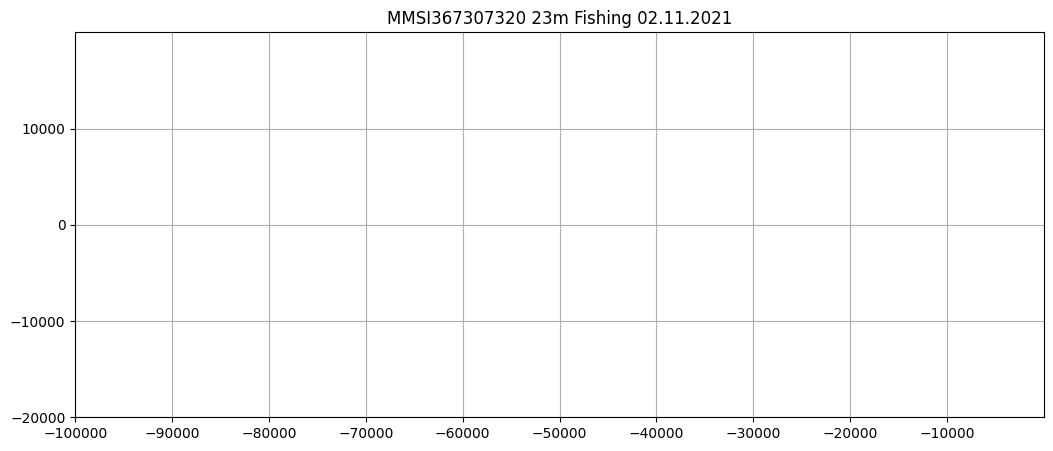

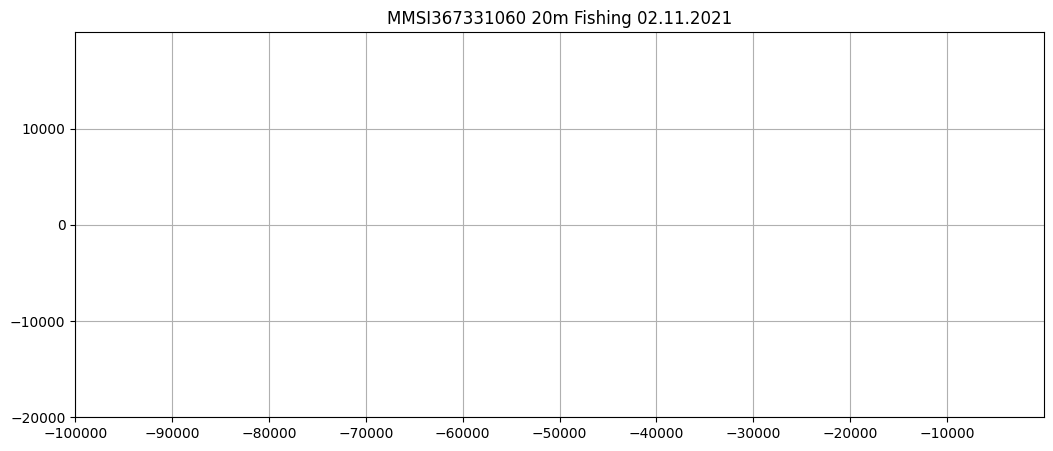

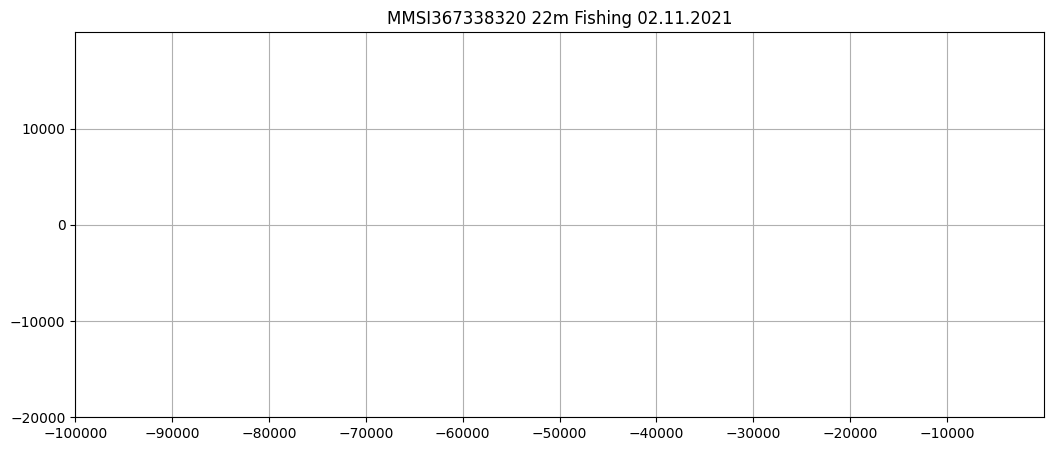

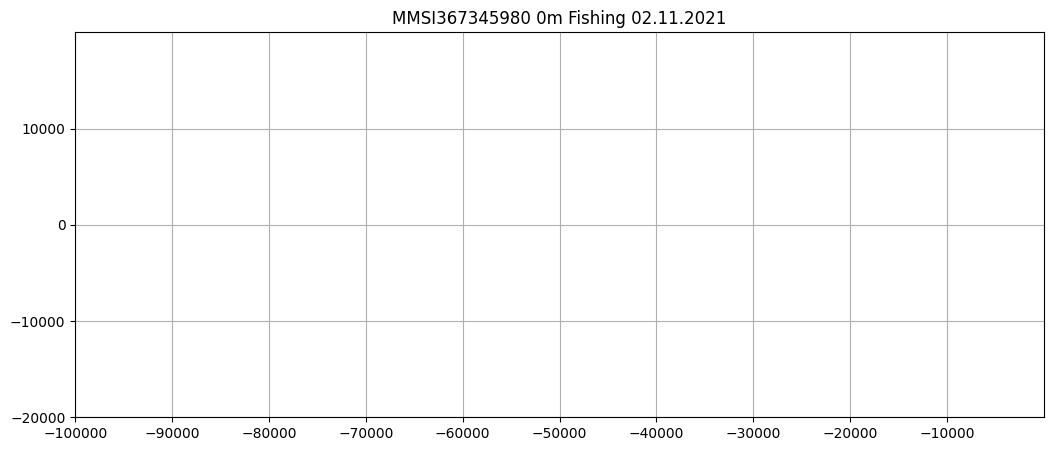

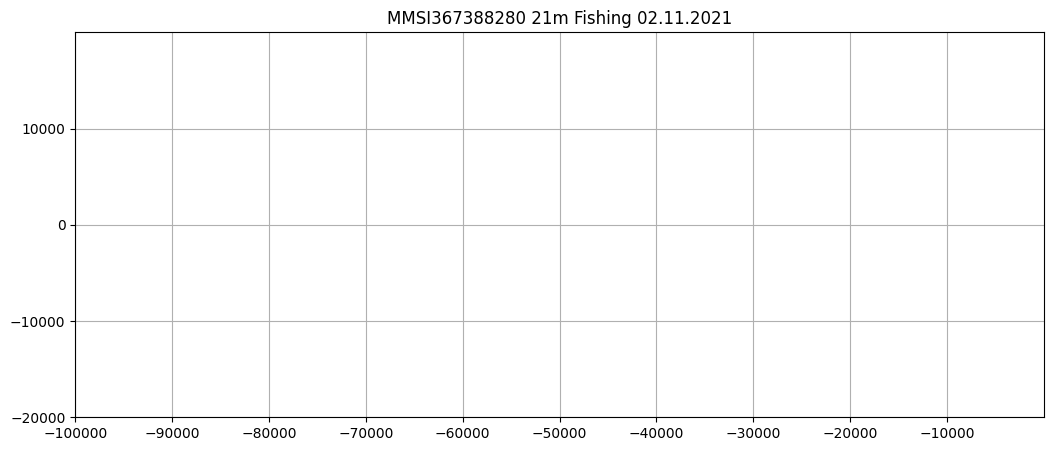

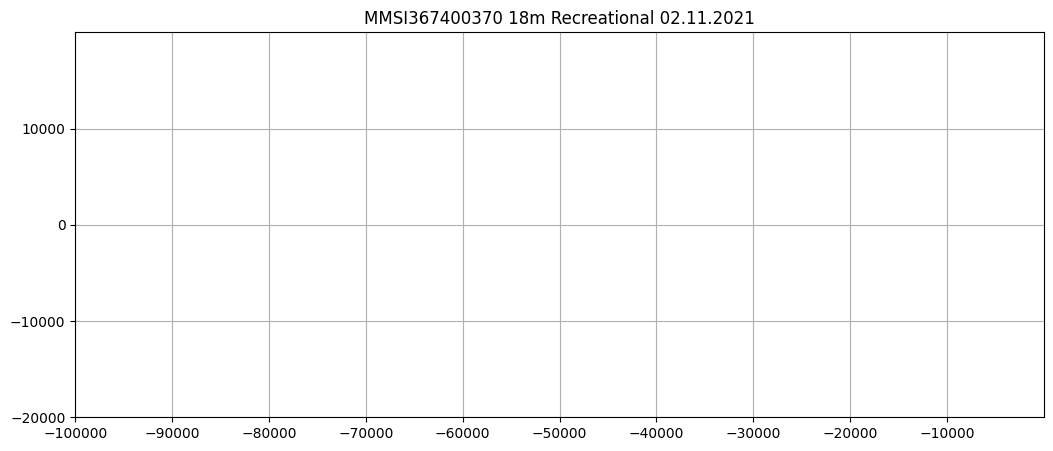

367426420 2021-11-01T01:32:48.000000000 414526.1932897952 5004232.552710683
367426420 2021-11-01T01:28:48.000000000 414608.43612869346 5005396.718871466


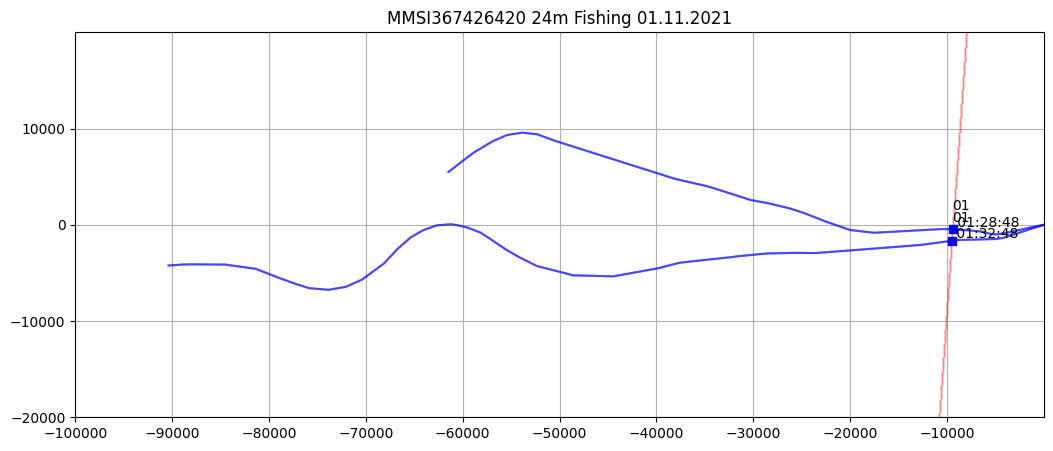

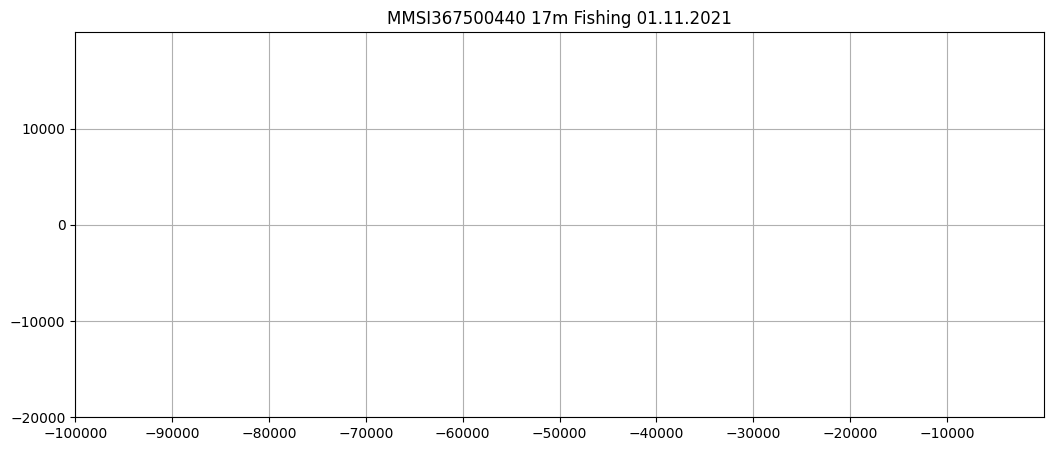

367553420 2021-11-02T10:34:08.000000000 363525.4714870019 5022087.499945933


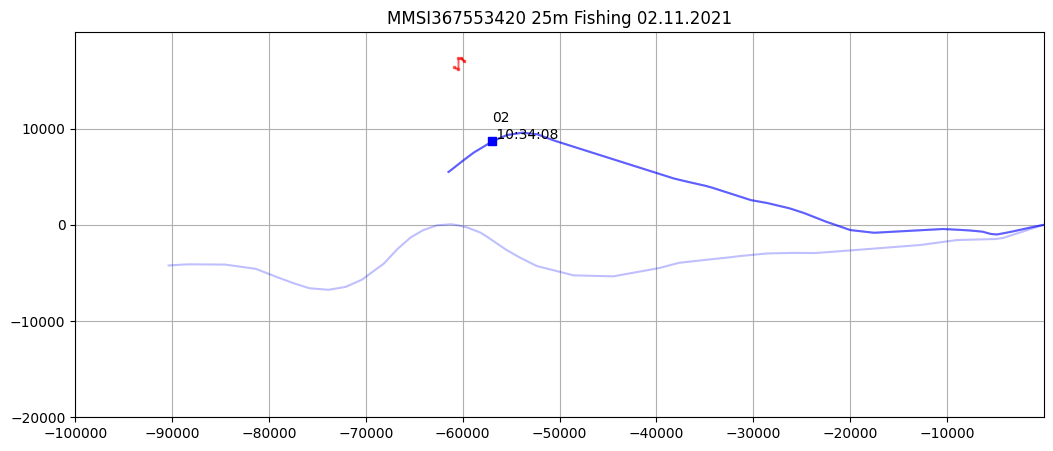

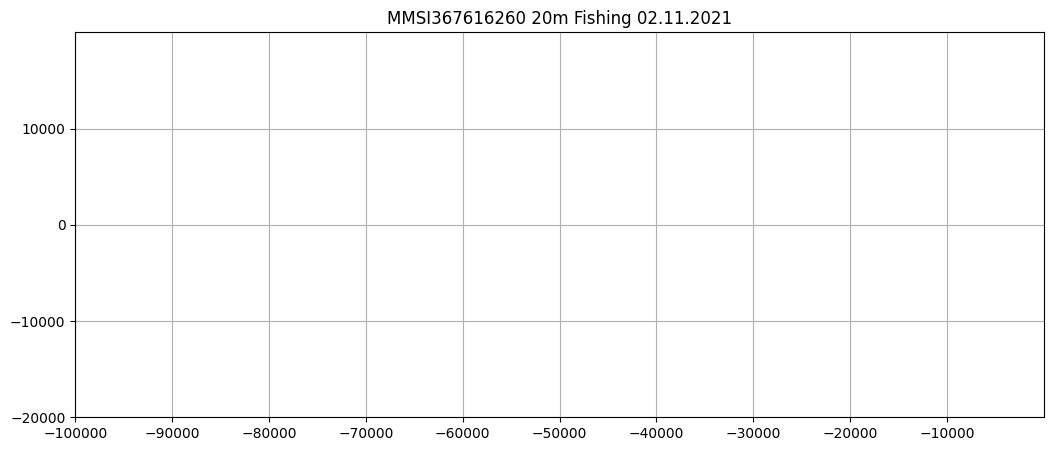

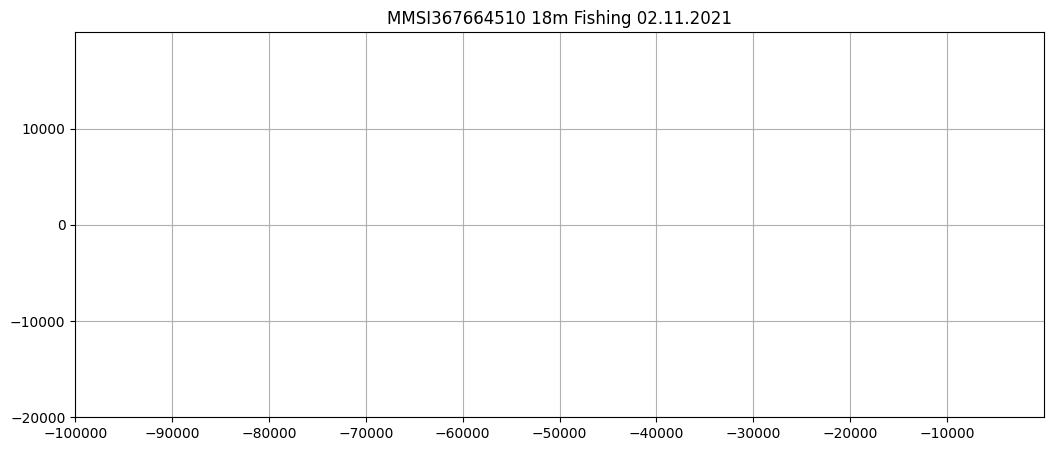

367709050 2021-11-02T07:29:42.000000000 376709.7473164773 5000610.647819662
367709050 2021-11-02T20:33:27.000000000 382077.2144856321 5011894.173349351


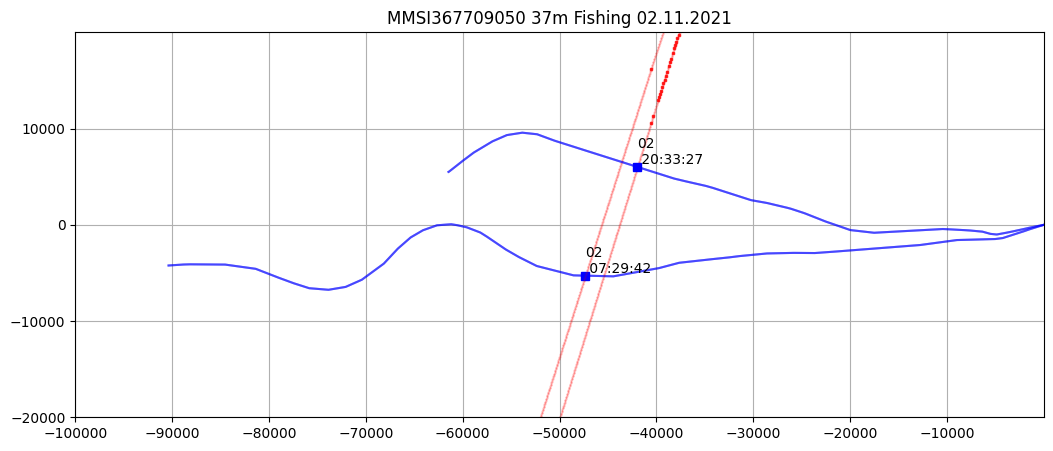

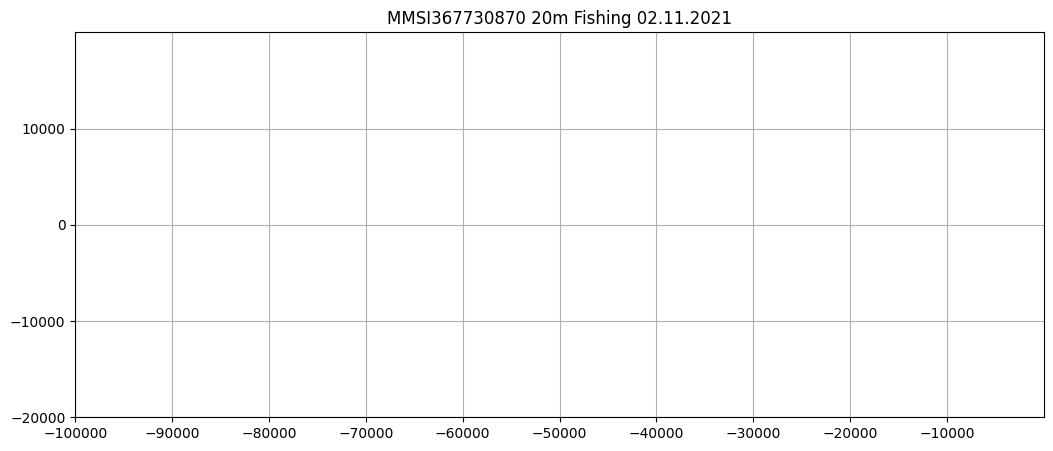

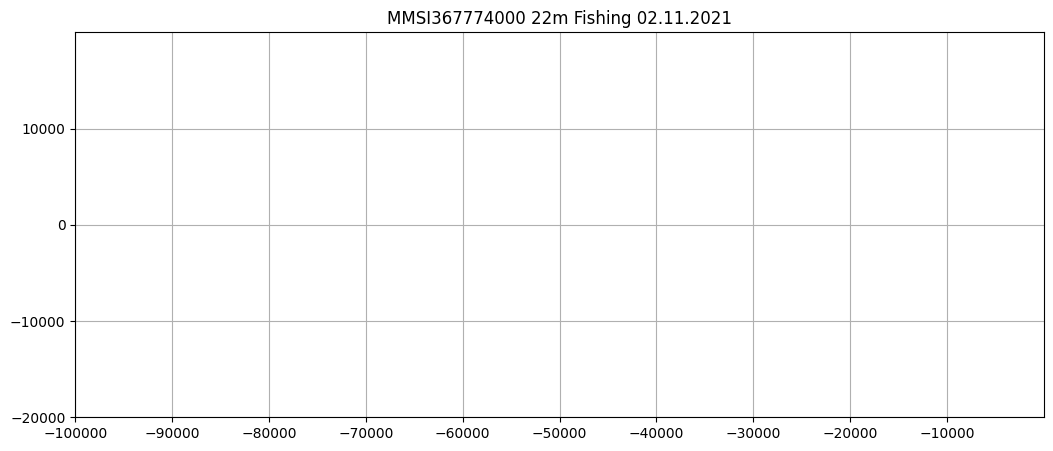

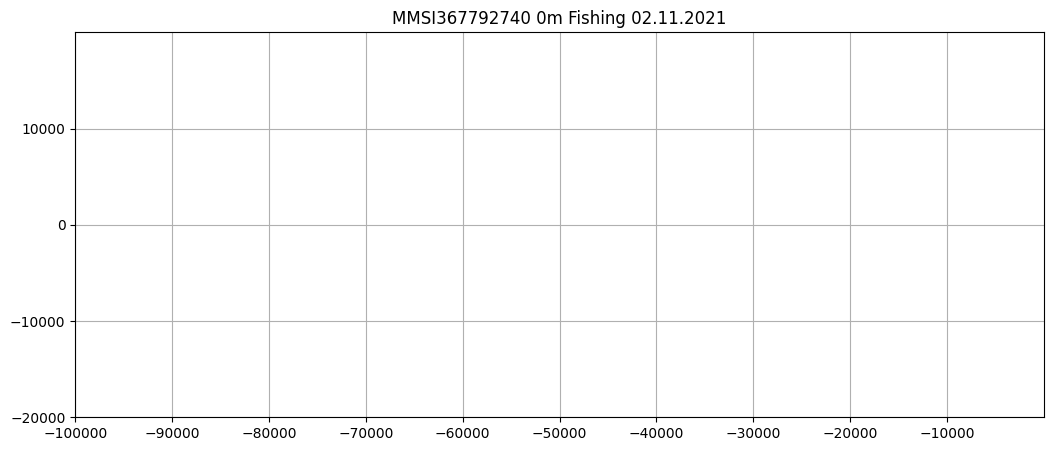

368038000 2021-11-04T05:17:46.000000000 372229.5516999178 5001445.706920244
368038000 2021-11-05T16:49:01.000000000 381228.1360659676 5012157.489345653


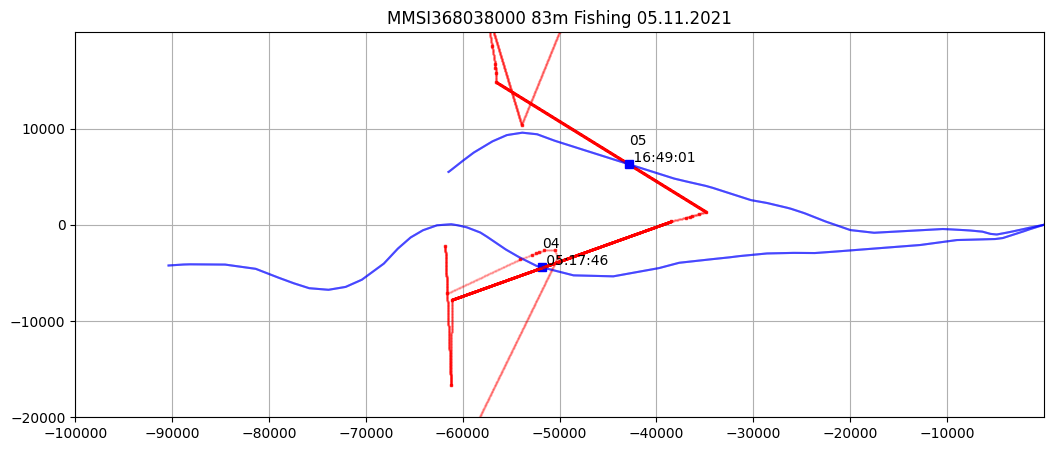

368049580 2021-11-01T07:18:25.000000000 412198.5832570171 5003921.124452279
368049580 2021-11-01T07:12:40.000000000 412423.7430596947 5005351.552678075


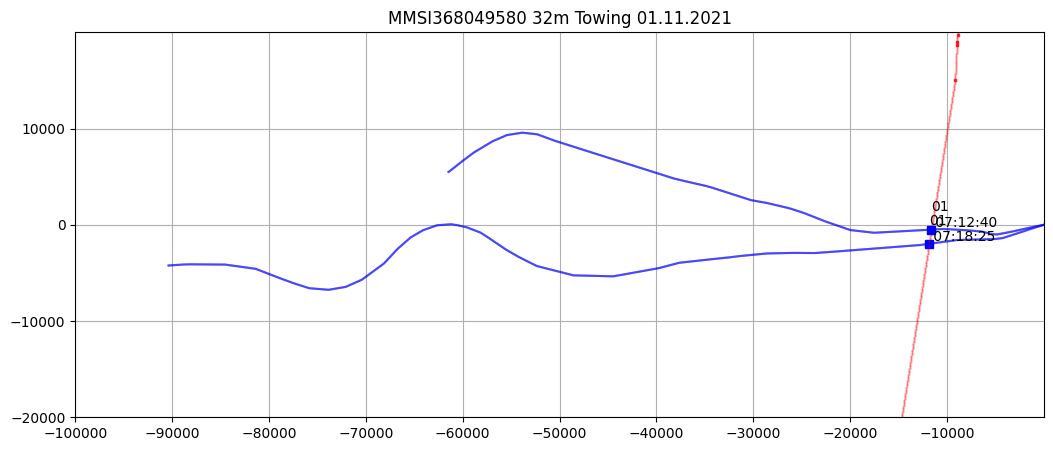

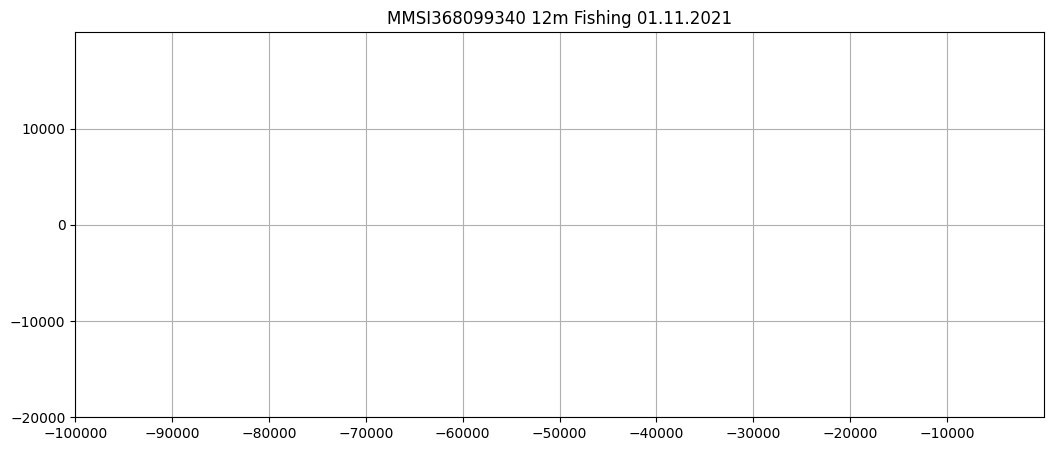

368206000 2021-11-03T04:40:34.000000000 405859.3670782946 5003362.31401118
368206000 2021-11-03T04:33:34.000000000 405914.1435411306 5005091.37666569


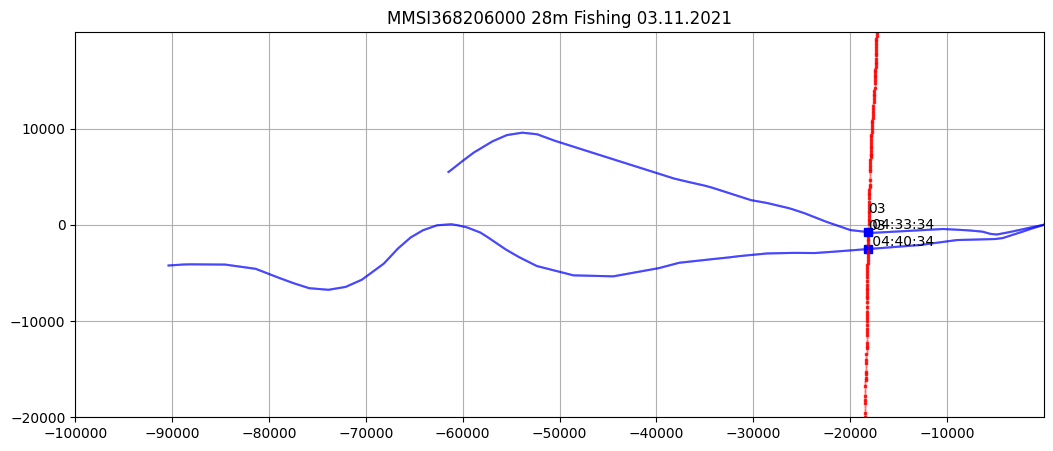

368293000 2021-11-03T09:21:59.000000000 356439.11835132673 5002415.370215946
368293000 2021-11-03T15:20:59.000000000 357202.75347858656 5011809.211949512


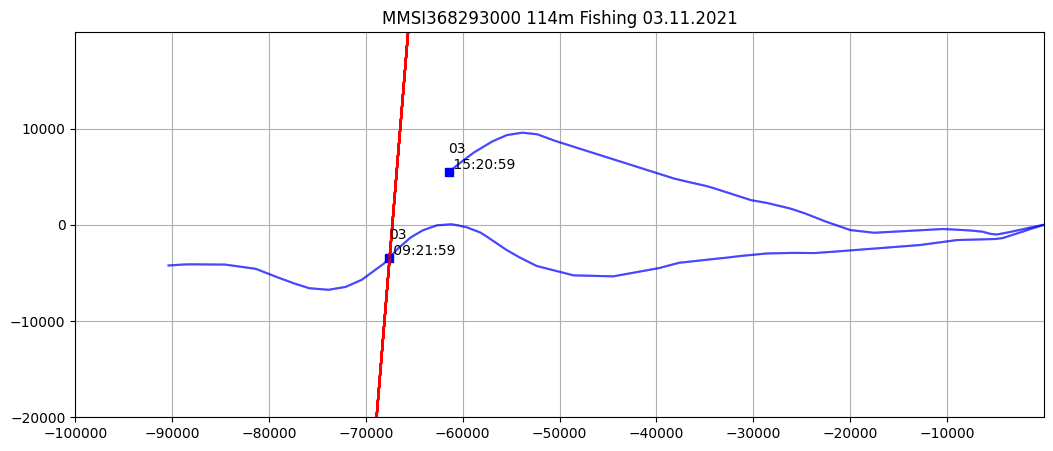

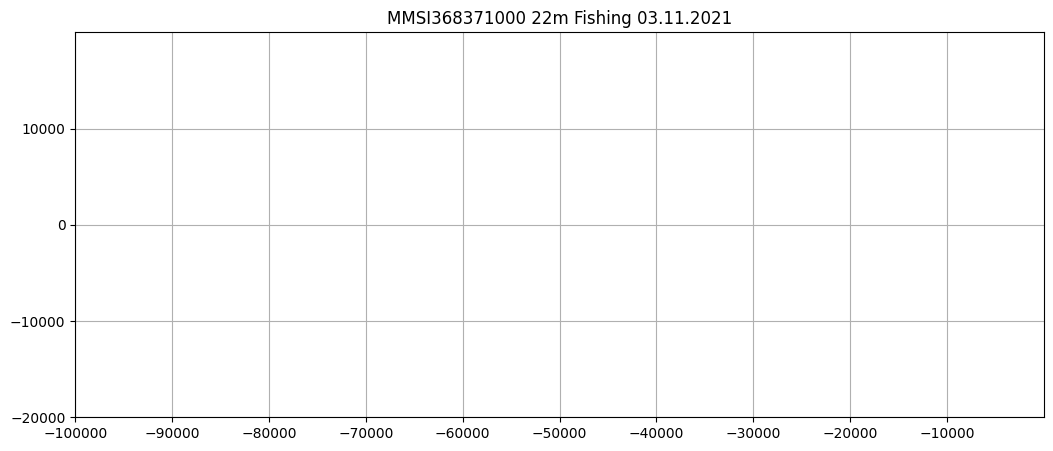

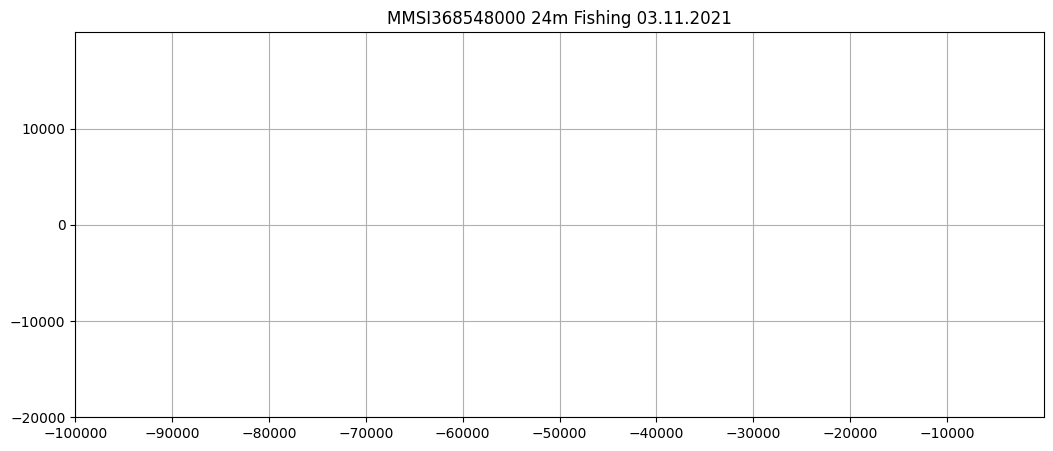

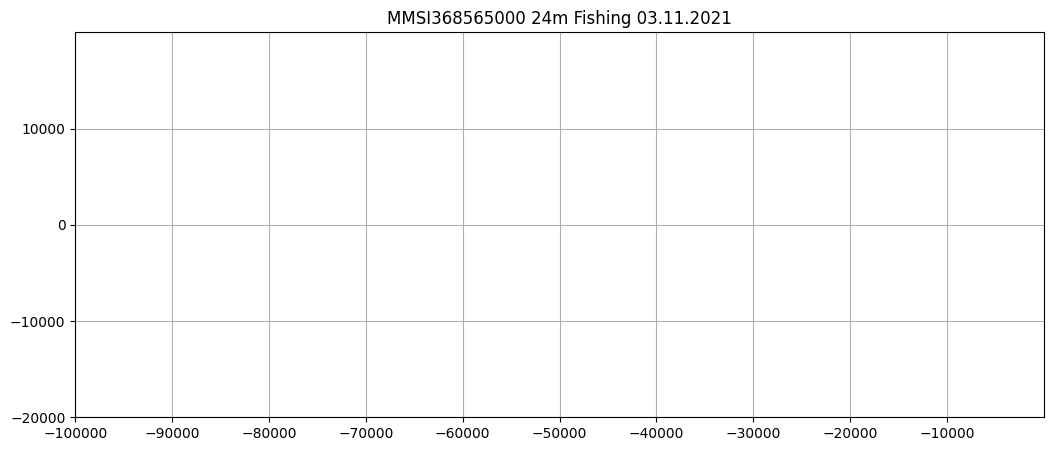

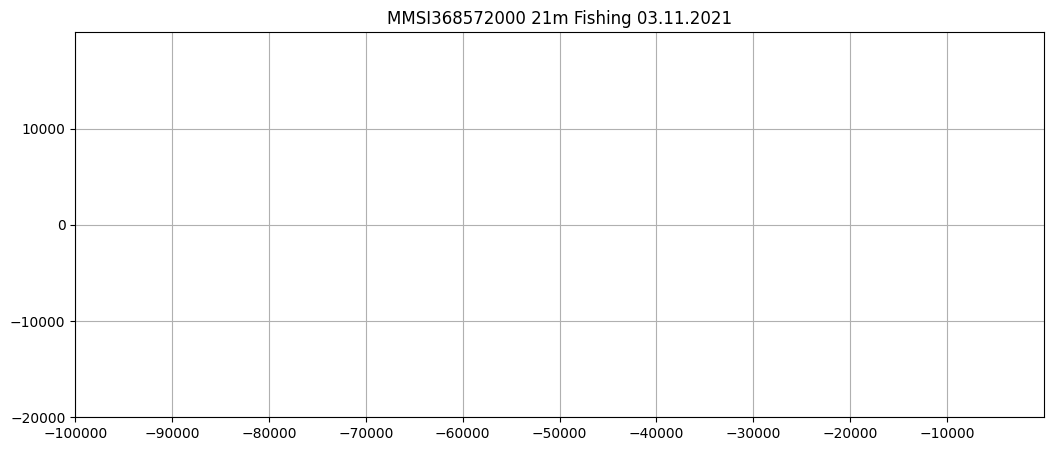

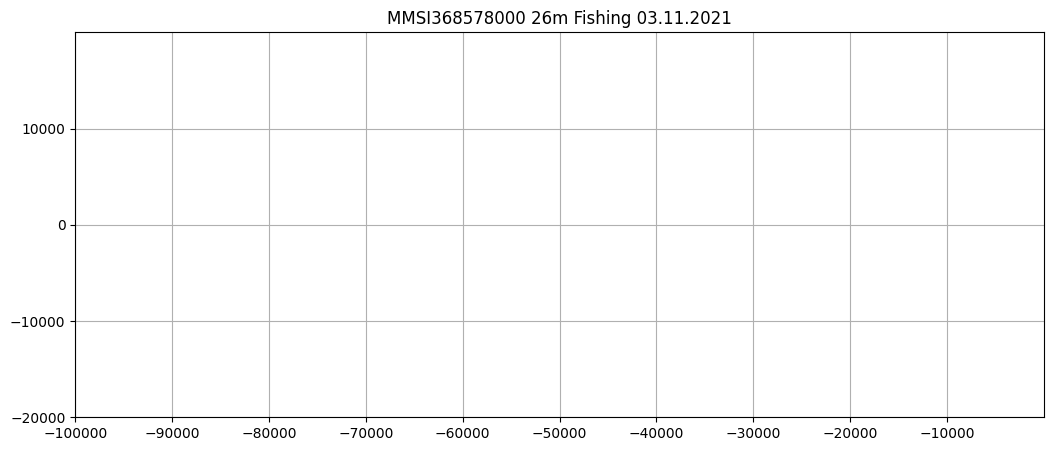

369493006 2021-11-02T08:45:34.000000000 368156.97229068173 5021413.122320848


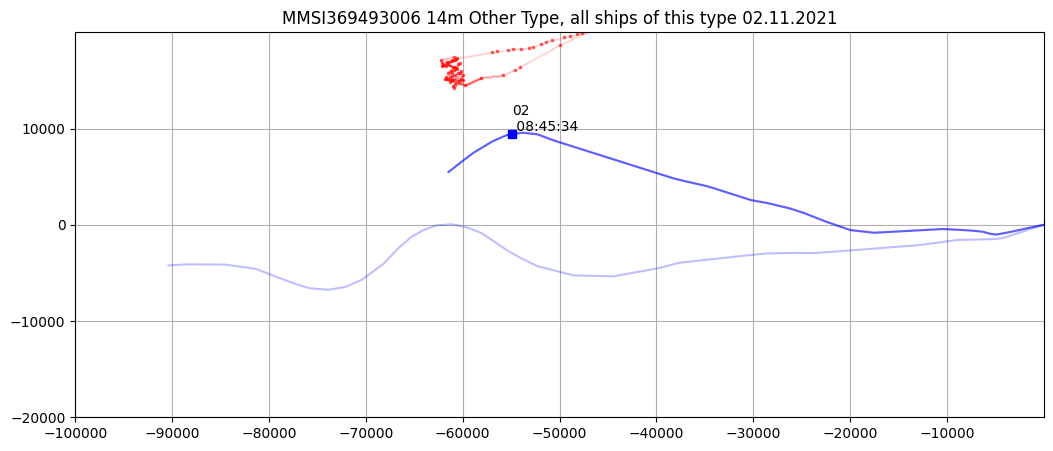

369499000 2021-11-02T03:01:01.000000000 358489.22610578546 5004420.96100627
369499000 2021-11-02T02:40:46.000000000 361155.4690187949 5011996.540192596


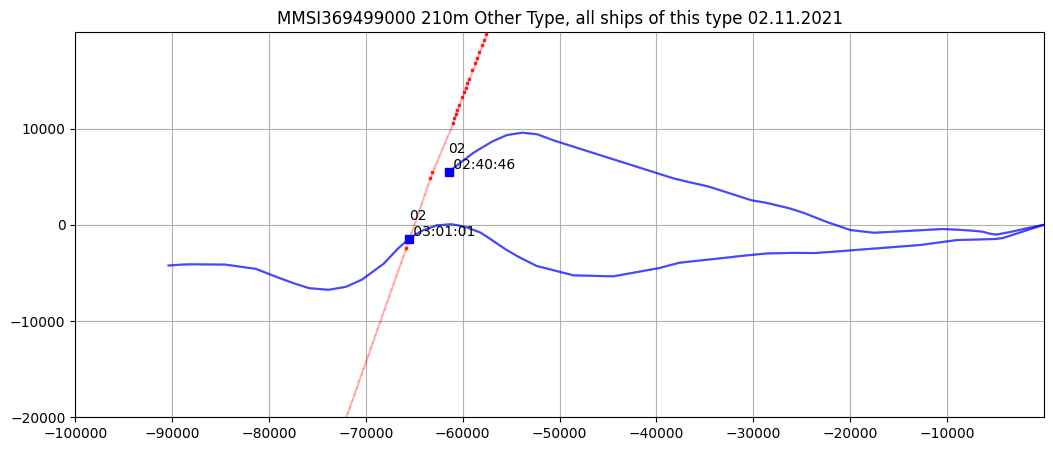

369604000 2021-11-01T14:23:08.000000000 364987.43488559255 5005389.066396847
369604000 2021-11-01T14:42:53.000000000 364742.83633125544 5013098.832804649


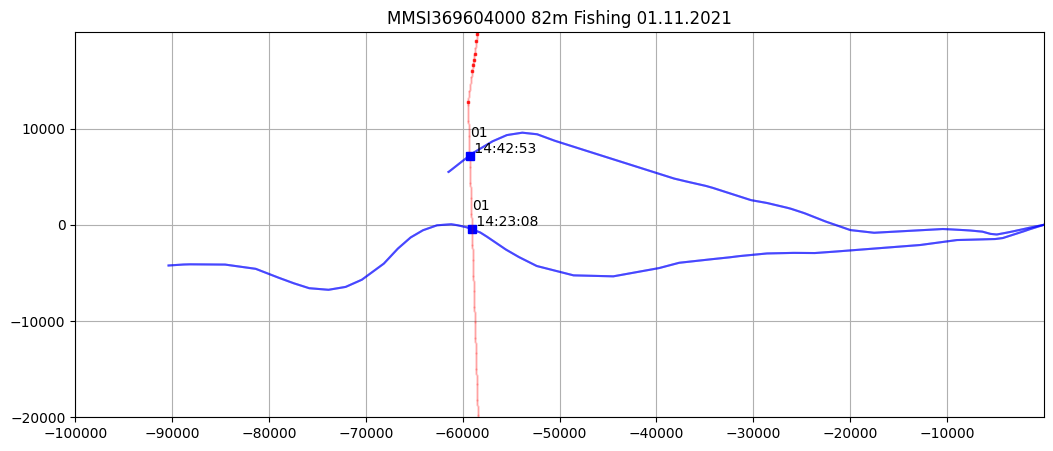

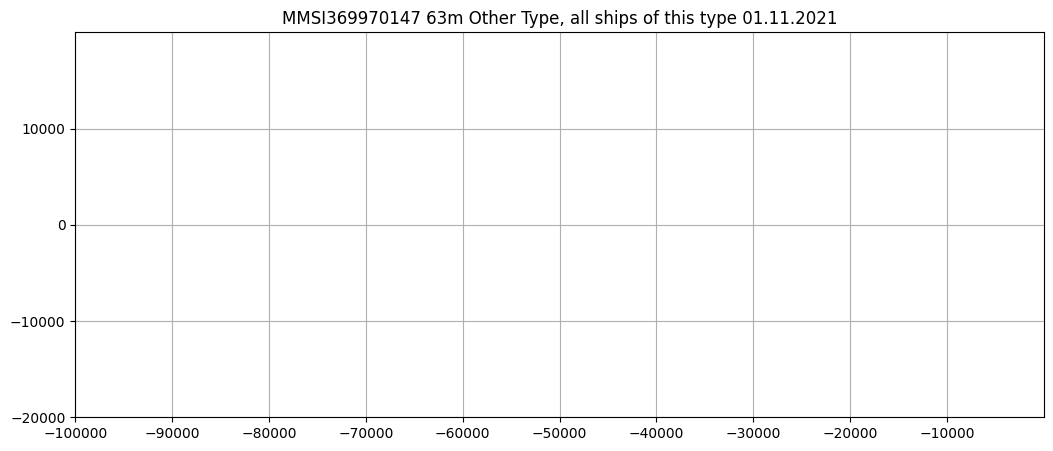

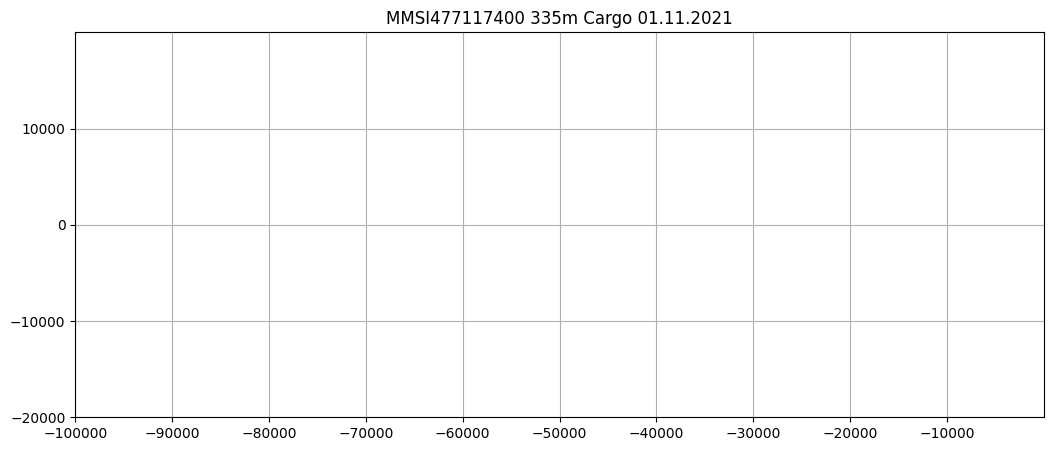

477852900 2021-11-01T22:02:56.000000000 346890.1154051967 4999672.553221769
477852900 2021-11-01T22:55:56.000000000 353241.7812958737 5014896.6097822385


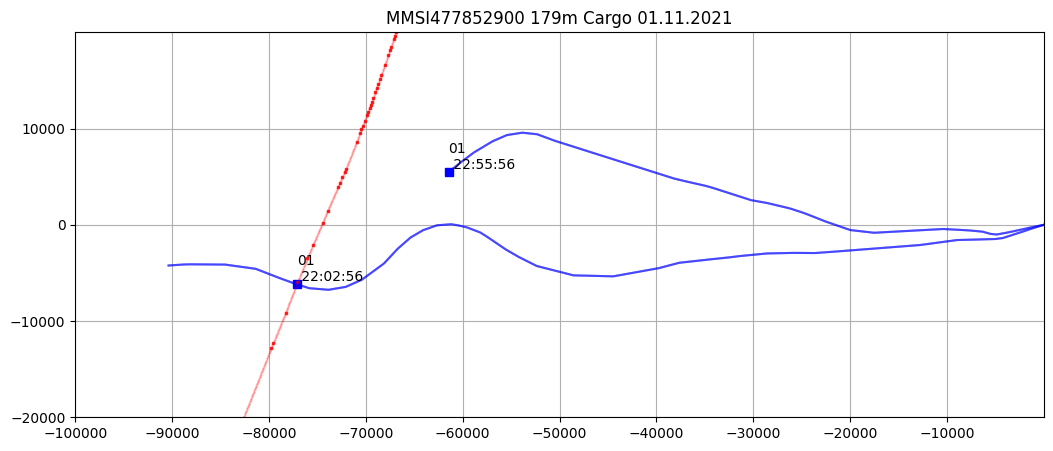

538007026 2021-11-01T07:56:40.000000000 407514.4081712234 5003467.487903656
538007026 2021-11-01T07:52:10.000000000 407801.01565988443 5005134.142942982


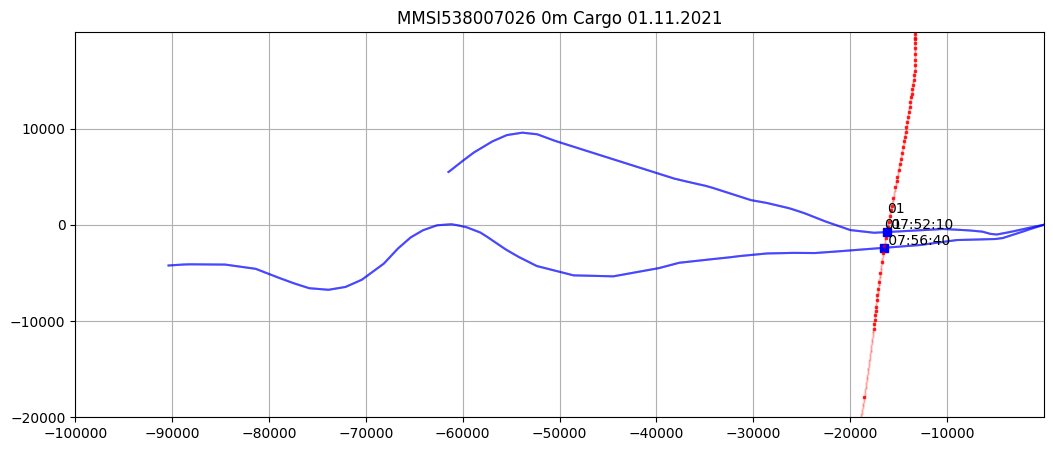

538007658 2021-11-01T07:55:48.000000000 379034.99307371874 5000565.494139008
538007658 2021-11-01T08:26:33.000000000 381467.9288223644 5012047.500539671


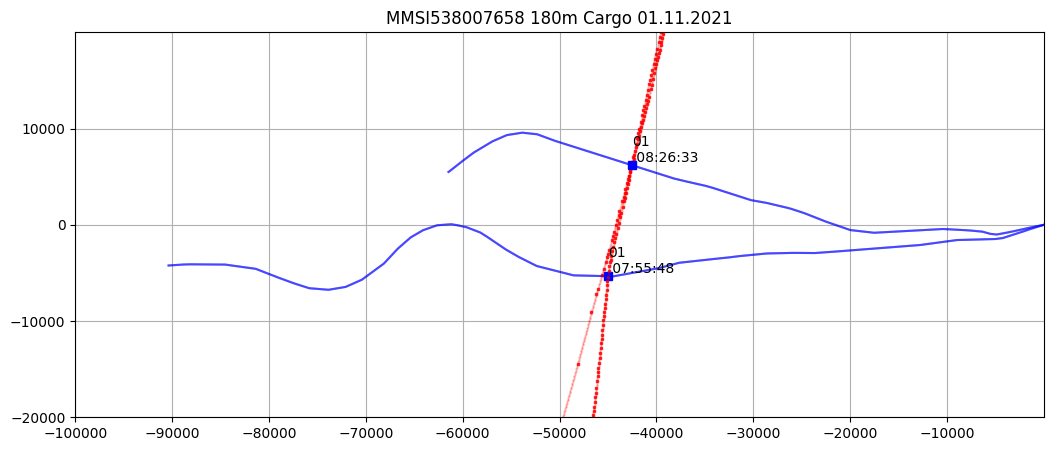

538007681 2021-11-02T07:35:34.000000000 394808.28137231356 5002834.635255276
538007681 2021-11-02T07:49:49.000000000 394692.2099555103 5008308.477828909


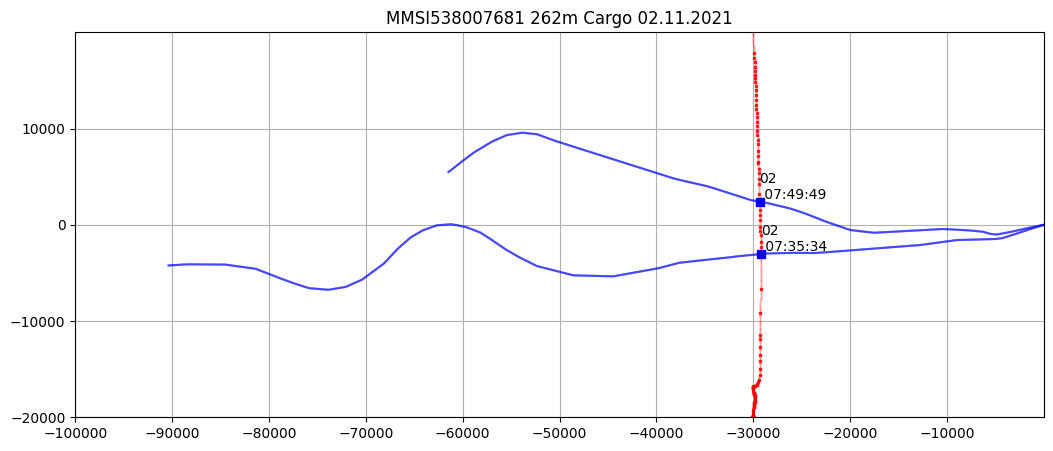

538008032 2021-11-05T16:41:09.000000000 378795.4065596707 5000511.449787157
538008032 2021-11-05T16:06:24.000000000 382300.06567903457 5011788.928803664


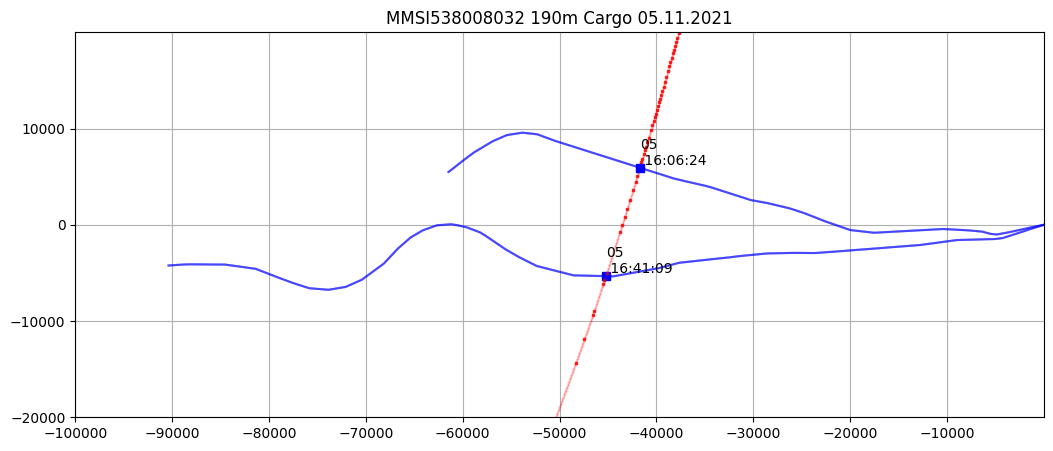

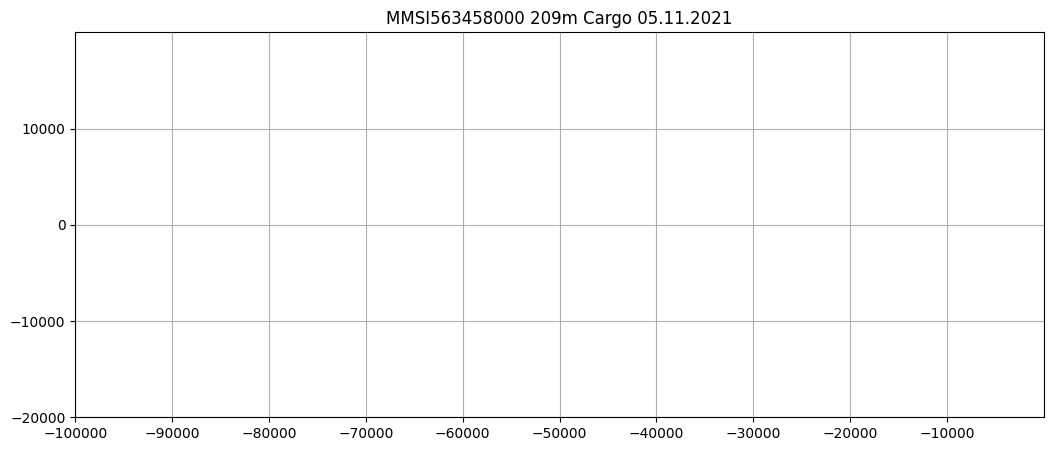

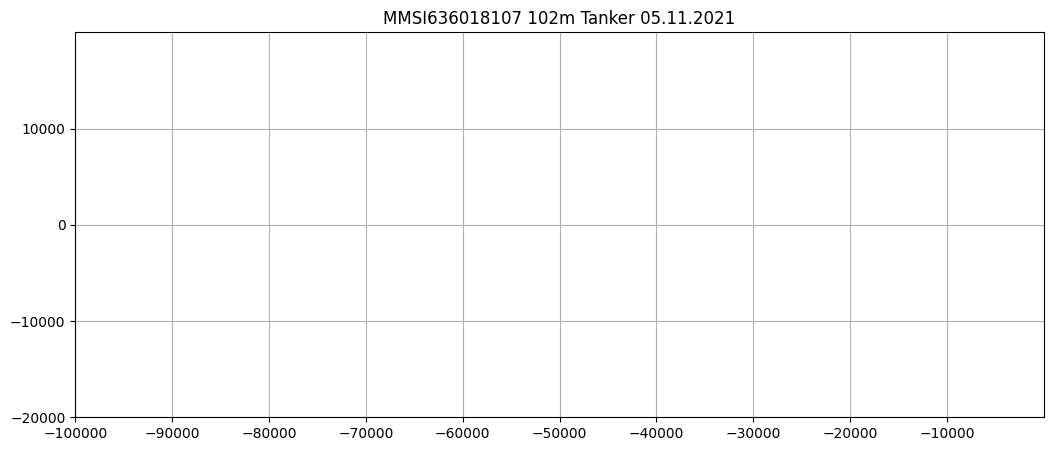

In [5]:
plt.figure(figsize=(8,4))

vesselsOfInterest = np.unique(df_Ais['MMSI'])

listOfClosest = []
for mmsi in vesselsOfInterest:

    mask           = df_Ais ['MMSI'       ] == mmsi
    vesselEasting  = df_Ais ['Easting'    ][mask].values
    vesselNorthing = df_Ais ['Northing'   ][mask].values
    vesselTime     = df_Ais ['DateTimeUTC'][mask].values

    vesselLength   = df_Ais ['Length'     ][mask].values[0]
    vesselType     = df_Ais ['Type'       ][mask].values[0]

    if np.isnan(vesselLength):
        
        vesselLength = 0
    
    if vesselEasting.shape[0] < 2: # Not enough data for vessel tracking

        continue

    indices        = np.argsort(vesselTime-np.min(vesselTime))
    vesselTime     = vesselTime     [indices]
    vesselEasting  = vesselEasting  [indices]
    vesselNorthing = vesselNorthing [indices]

    time0          = vesselTime[0]

    t = np.array([(t-time0)/ np.timedelta64(1, 's') for t in vesselTime])

    ti = np.arange(t[0],t[-1],15)
    xi = np.interp(ti,t,vesselEasting)
    yi = np.interp(ti,t,vesselNorthing)

    ti = np.array( [(time0+np.timedelta64(tii.astype('int'),'s')) for tii in ti])
    
    plt.figure(figsize=(12.5,5))
    for l in [(df_SouthCable,'South'),(df_NorthCable,'North')]:
    
        df_Cable  = l[0]
        cableName = l[1]

        cableEasting  = df_Cable['Easting' ].values
        cableNorthing = df_Cable['Northing'].values
        cableDepth    = df_Cable['Depth'   ].values

        times      = []
        distances  = []
        depths     = []
        location   = []
        for j in range(ti.shape[0]):

            ddd = np.hypot(cableEasting  - xi [j],\
                           cableNorthing - yi [j]) 

            location  .append( np.argmin(ddd) )
            distances .append( np.min   (ddd) )
            depths    .append( -1*cableDepth[location[-1]] )
            times     .append( (ti[j]-time0 ) // np.timedelta64(1, 's') )

        idd                       = np.argmin(distances)
        timeOfClosestApproach     = ti       [ idd ]
        eastingOfClosestApproach  = xi       [ idd ]
        northingOfClosestApproach = yi       [ idd ]
        locOfClosestApproach      = location [ idd ]
        distOfClosestApproach     = np.min   (distances)

        if min(distances) < 10.0e3:

            print(mmsi,
                  timeOfClosestApproach,
                  eastingOfClosestApproach,
                  northingOfClosestApproach)

            listOfClosest.append( [mmsi,
                                   vesselType,
                                   vesselLength,
                                   timeOfClosestApproach,
                                   distOfClosestApproach,
                                   locOfClosestApproach,
                                   eastingOfClosestApproach,
                                   northingOfClosestApproach,
                                   cableName,
                                   pd.to_datetime(timeOfClosestApproach).strftime('%Y%m%d_%H%M%S')] )

            if False:
                
                plt.figure(figsize=(8,3))

                plt.subplot(2,1,1)
                plt.plot(ti,distances,'k.-')
                plt.ylim(0,10e3)
                plt.gcf().autofmt_xdate()
                plt.grid()

                plt.subplot(2,1,2)
                plt.plot(ti,depths,'k.-')
                plt.ylim(0,1e3)
                #plt.xlim(0,(endTime-startTime).total_seconds())
                #plt.xticks(np.arange(0,(endTime-startTime).total_seconds(),60*60*24))
                #plt.yticks(np.arange(0,10e3,2e3))
                plt.gcf().autofmt_xdate()
                plt.grid()

                plt.suptitle(str(mmsi)+' : '+str(timeOfClosestApproach))
                plt.savefig('./time_'+str(mmsi)+'png')
                plt.show()

            
            mask = df_Ais ['MMSI'] == mmsi
            #plt.plot(xi -cableEasting [0],
            #         yi-cableNorthing[0],'r-',alpha=0.25)
            plt.plot(xi -cableEasting [0],
                     yi-cableNorthing[0],'r.',
                     alpha=0.1,
                     markersize=1)
            plt.plot(vesselEasting  - cableEasting [0],
                     vesselNorthing - cableNorthing[0],'rs',
                     alpha=0.5,
                     markersize=2)
            plt.plot(df_SouthCable['Easting' ] - df_SouthCable['Easting' ][0],
                     df_SouthCable['Northing'] - df_SouthCable['Northing'][0],
                     'b-',alpha=0.25)
            plt.plot(df_NorthCable['Easting' ] - df_NorthCable['Easting' ][0],
                     df_NorthCable['Northing'] - df_NorthCable['Northing'][0],
                     'b-',alpha=0.25)
            plt.plot(cableEasting  - cableEasting  [0],
                     cableNorthing - cableNorthing [0],
                     'b-',alpha=0.5)
            
            plt.plot(cableEasting [locOfClosestApproach]  - cableEasting  [0],
                     cableNorthing[locOfClosestApproach] - cableNorthing [0],
                     'bs',alpha=1.0)
            
            dtt = pd.to_datetime(str(timeOfClosestApproach)).strftime('%d.%m.%Y %H:%M:%S')
            
            plt.text(cableEasting [locOfClosestApproach]  - cableEasting  [0],
                     cableNorthing[locOfClosestApproach] - cableNorthing [0]+300,
                     dtt[0:2]+"\n"+dtt[10:])
                                     
    plt.xlim(-100e3,0)
    plt.ylim(-20e3,20e3)
    plt.xticks(np.arange(-100e3,  0,10e3))
    plt.yticks(np.arange(-20e3,20e3,10e3))
    plt.grid()
    plt.title('MMSI'+str(mmsi)+' '+str(int(vesselLength))+'m '+vesselType+' '+dtt[0:10])
    plt.xlabel('Easting [km]')
    plt.ylabel('Northing [km]')
    plt.savefig('./track_'+str(mmsi)+'png')
    plt.show()

df_Closest= pd.DataFrame(listOfClosest,columns=['MMSI',
                                                'Type',
                                                'Length',
                                                'timeOfClosestApproach',
                                                'distOfClosestApproach',
                                                'locationOfClosestApproach',
                                                'eastingOfClosestApproach',
                                                'northingOfClosestApproach',
                                                'Cable',
                                                'datetime'])

if False:
    df_Closest.to_csv(r'../../Documentation/AisData/ClosestVessels.csv')

# Vessel crossing example

We can use the dates and times which have vessel crossings to then look for the actual vessel event in the recorded data.

Below, we have an example of vessel 352927000 which crosses the south cable at 2:08 on 4/11/2021. As we know the exact time that the crossing occurs, we can zoom in to the plotted data closer to the exact time of 2:08:17 to get a better look at where the vessel might be making noise.

Number of mat Files:  1


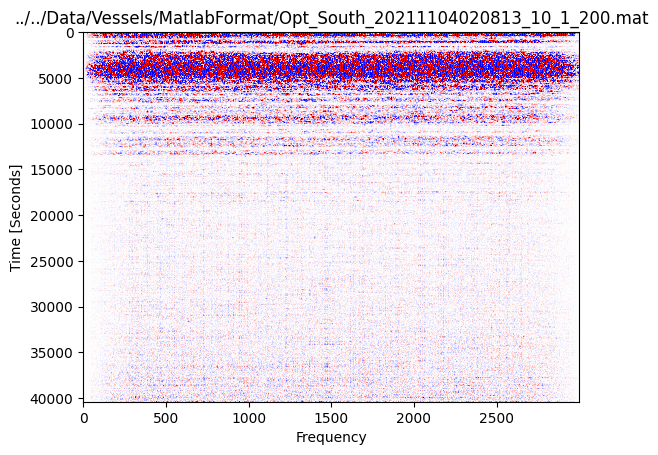

In [45]:
import glob
import scipy.fft
import scipy.io
import datetime as dt
import numpy as np

from skimage.measure import block_reduce
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter

def applyCosineTaper(Data,TaperLength=20):

    numberOfSamples = Data.shape[-1]
    taper           = np.sin(0.5*np.pi*np.arange(0,TaperLength)/(TaperLength-1))

    window     = np.ones(numberOfSamples)
    window[0:TaperLength] = taper
    window[-TaperLength:] = taper[::-1]

    return Data*window

def butter_bandpass(lowcut, highcut, fs, order=5):
    
    if lowcut <= 0:
        return butter(order, highcut, fs=fs, btype='low', analog=False)
    else:
        return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

dataDir = r'../../Data/Vessels/MatlabFormat/'
files   = sorted(glob.glob(dataDir+'Slx_South_20211104020813_10_1_200.mat'))

print('Number of mat Files: ',len(files))

for file in files:
    
    data = scipy.io.loadmat(file)['data']
    numberOfChannels,\
    numberOfSamples = data.shape

    samplingFrequency = float(file[0:-4].split("_")[-1])
    gaugeLength       = float(file[0:-4].split("_")[-2])
    channelSpacing    = float(file[0:-4].split("_")[-3])
    
    timeStamp         = file[file.rfind("_2021")+1:file.rfind("_2021")+15]
    dateTime          = dt.datetime.strptime(timeStamp, '%Y%m%d%H%M%S')
    
    mean1 = np.mean(data,axis=1)

    bdata = butter_bandpass_filter(applyCosineTaper((data.T - mean1).T,400),\
                                   10, 30, fs=samplingFrequency, order=5)
    
    vMax = np.percentile(bdata[::,::],90)
    plt.imshow(bdata[::,::],aspect='auto',cmap='bwr',vmin=-vMax,vmax=vMax)
    plt.title(file)
    plt.xlabel('Frequency')
    plt.ylabel('Time [Seconds]')
    plt.show()

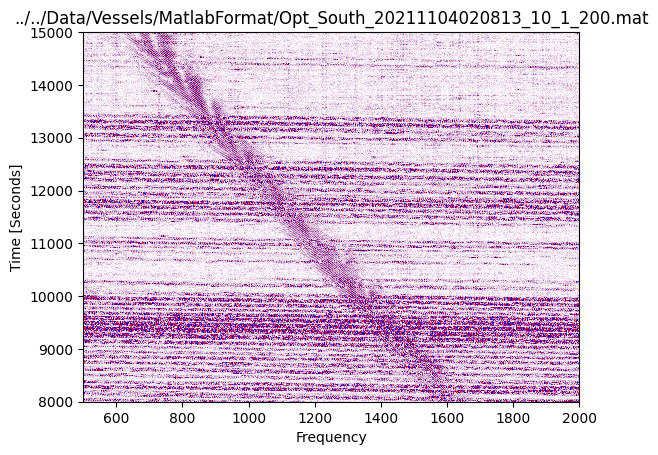

In [48]:
plt.imshow(bdata[::,::],aspect='auto',cmap='bwr',vmin=-vMax,vmax=vMax)
plt.title(file)
plt.xlabel('Frequency')
plt.ylabel('Time [Seconds]')
plt.xlim(500,2000)
plt.ylim(8000,15000)

plt.show()